In [307]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Leitura do conjunto de dados
df_cars_train = pd.read_csv('cars_train.csv', sep='\t', encoding='utf_16_le')

In [308]:
# Remoção das linhas duplicadas
print('Before removing duplicates: ', len(df_cars_train))
df_cars_train.drop_duplicates()
print('After removing duplicates: ', len(df_cars_train))

Before removing duplicates:  29584
After removing duplicates:  29584


In [309]:
# Visualizando informações básicas do conjunto de dados
print(df_cars_train.info())
print(df_cars_train.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       29584 non-null  object 
 1   num_fotos                29407 non-null  float64
 2   marca                    29584 non-null  object 
 3   modelo                   29584 non-null  object 
 4   versao                   29584 non-null  object 
 5   ano_de_fabricacao        29584 non-null  int64  
 6   ano_modelo               29584 non-null  float64
 7   hodometro                29584 non-null  float64
 8   cambio                   29584 non-null  object 
 9   num_portas               29584 non-null  int64  
 10  tipo                     29584 non-null  object 
 11  blindado                 29584 non-null  object 
 12  cor                      29584 non-null  object 
 13  tipo_vendedor            29584 non-null  object 
 14  cidade_vendedor       

<Axes: >

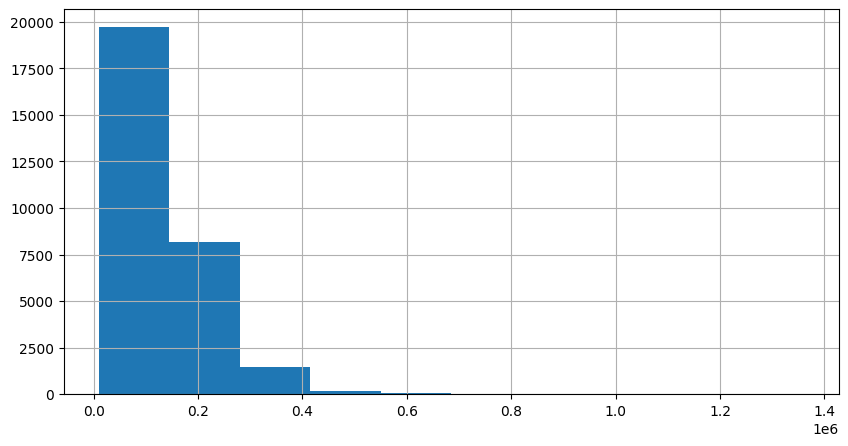

In [315]:

df_cars_train['preco'].hist(figsize=(10,5))

In [296]:
# Análise e tratamento de cada coluna 
# ['ID']
# Conforme esperado existe um valor único de 'id' para cada linha do conjunto de dados. Trata-se de uma variável categorical
# que não possui relação com a variável target. Por isso, será removida.
df_cars_train.drop(['id'], axis=1, inplace=True)

Valores NaN na coluna num_fotos ANTES de tratamento:  0.6 %
Valores NaN na coluna num_fotos DEPOIS de tratamento:  0.0 %


<Axes: xlabel='num_fotos'>

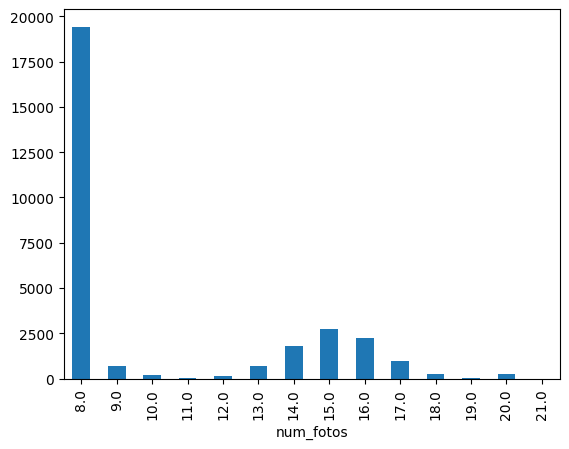

In [305]:
#['num_fotos']
print('Valores NaN na coluna num_fotos ANTES de tratamento: ',
      round(((df_cars_train['num_fotos'].isna().sum() / len(df_cars_train)) * 100), 1), '%')

# A coluna possui 177 valores NaN, o que equivale a 0.6%. Como o número de linhas é muito pequeno, decidi substituir seus valores
# pela média do número de fotos no conjunto de dados.

df_cars_train['num_fotos'].fillna(value=round(df_cars_train['num_fotos'].mean()), inplace=True)

print('Valores NaN na coluna num_fotos DEPOIS de tratamento: ',
      round(((df_cars_train['num_fotos'].isna().sum() / len(df_cars_train)) * 100), 1), '%')

# Visualização da distribuição
df_cars_train.groupby(df_cars_train['num_fotos']).size().plot(kind='bar')

# Trata-se de uma variável quantitativa discreta e pode ter relação com a variável target. A distribuição é irregular, uma vez 
# que a maior parte dos dados possui 8 fotos. É uma indicação que talvez essa variável não seja produtiva para o modelo de 
# aprendizado de máquina.

In [317]:
# ['marca']
# A coluna marca é uma variável categórica. O número de categorias é, no entanto, um pouco grande. Além disso, algumas categorias
# são bem pouco frquentes no conjunto de dados, como pode ser observado com o código abaixo.

print('Percentual de entradas por', (df_cars_train['marca'].value_counts() / len(df_cars_train))* 100)

# Um grande número de categorias pode ter efeitos negativos no algoritmo de aprendizagem de máquina. Por essa razão, ele será
# diminuído. As marcas que representarem menos de 1% do conjunto de dados serão reunidas numa categoria chamada 'outra'.

marca_frequencia = df_cars_train['marca'].value_counts() / len(df_cars_train)
marcas_menos_frequentes = marca_frequencia[marca_frequencia<0.01]
df_cars_train.loc[df_cars_train['marca'].isin(marcas_menos_frequentes.index.tolist()), 'marca'] = 'OUTRA'

# Visualização da distribuição
df_cars_train.groupby(df_cars_train['marca']).size().plot(figsize=(10,5), kind='bar')

# Trata-se de um variável categórica e a distribuição é bastante regular. É um sinal positivo para que ela seja utilizada no 
# modelo de aprendizado de máquina.


Percentual de entradas por marca
VOLKSWAGEN       15.528664
CHEVROLET        10.208221
TOYOTA            7.368848
HYUNDAI           6.905760
JEEP              6.760411
FIAT              6.483234
BMW               6.030287
AUDI              5.739589
PEUGEOT           5.661844
HONDA             5.361006
OUTRA             5.225798
MERCEDES-BENZ     3.802731
FORD              3.583018
MITSUBISHI        2.913737
LAND ROVER        2.568956
RENAULT           1.818551
NISSAN            1.480530
KIA               1.379124
PORSCHE           1.179692
Name: count, dtype: float64


TypeError: GroupBy.size() got an unexpected keyword argument 'figsize'

<Axes: xlabel='marca'>

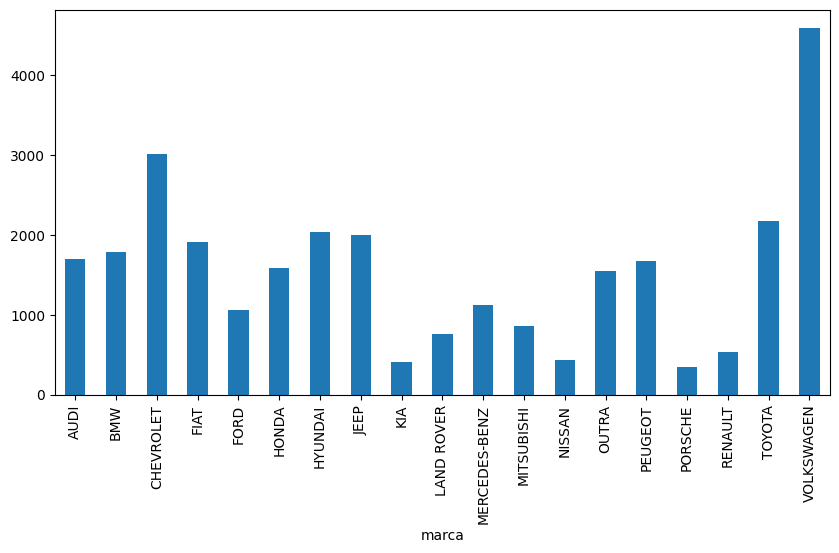

In [318]:
df_cars_train.groupby(df_cars_train['marca']).size().plot(figsize=(10,5), kind='bar')

In [8]:
# ['modelo']
# A coluna 'modelo' também contém variáveis categóricas mas seu número é muito maior do que no caso das marcas. Nesse caso, 
# a estratégia será simplesmente remover a coluna. Não removerei nesse momento porque precisarei dela para responder uma das 
# questões na EDA.

#df_cars_train.drop(['modelo'], axis=1, inplace=True)

<Axes: xlabel='tipo_combustivel'>

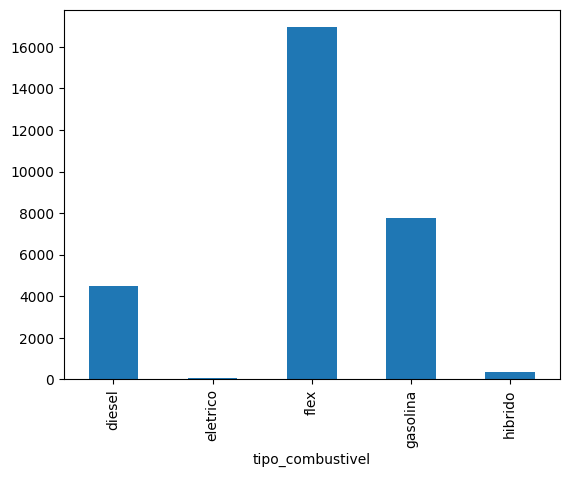

In [319]:
# ['versao']
# A coluna 'versao' contém uma descrição do veículo qeu contempla algumas caracerísticas técnicas possivelmente relevantes para
# o problema. Embora exista alguma lógica nessa descrição (todas começam pelo número de cilindradas, por exemplo), ela nem sempre é 
# coerente (os carros elétricos não possuem cilindradas). Além disso, há problemas com nomeclatura. Carros flex muitas vezes são 
# descritos como 'flexstart', 'flexone', 'hi-flex', etc. Híbridos e elétricos são descritos em inglês (electric, hybrid). 
# O código abaixo lida com todas essas particularidades. É importante mencionar que, no caso dos carros elétricos, o valor 2.0
# foi forçadamente passado para a coluna 'cilindrada'. O certo seria possuir uma coluna 'potencia' que contivesse valores em cv 
# (cavalos a vapor). Este unidade existe tanto para carros com motores a combustão quanto para carros com motores elétricos. Para 
# utilizá-la, no entanto, seria preciso coletar mais dados em outras fontes e rearranjar o conjunto de dados em análise. Para não 
# abrir mão da variável nem tampouco dos modelos elétricos, o valor 2.0 foi passado como um suposta equivalência com os carros a 
# combustão.

# Criando as novas colunas
df_cars_train.insert(3, 'cilindrada', np.NaN)
df_cars_train.insert(4, 'tipo_combustivel', np.NaN)

# Preenchendo as novas colunas a partir da coluna 'versao'
tipos = ['flex', 'gasolina', 'diesel', 'híbrido', 'hybrid']
for i in range(len(df_cars_train)):
    if 'elétrico' in df_cars_train.loc[i, 'versao'].lower() or 'electric' in df_cars_train.loc[i, 'versao'].lower():
        df_cars_train.loc[i, 'tipo_combustivel'] = 'eletrico'
        df_cars_train.loc[i, 'cilindrada'] = 2.0
    else:
        df_cars_train.loc[i, 'cilindrada'] = float(df_cars_train['versao'][i][0:3])
        for tipo in tipos:
            if tipo in df_cars_train.loc[i, 'versao'].lower():                
                if tipo == 'híbrido' or tipo == 'hybrid':
                    df_cars_train.loc[i, 'tipo_combustivel'] = 'hibrido'
                else:
                    df_cars_train.loc[i, 'tipo_combustivel'] = tipo
                
# Preenchendo o 'tipo_combustivel' com a moda para as entradas que não continham essa informação
df_cars_train['tipo_combustivel'].fillna(value=(df_cars_train['tipo_combustivel'].mode()[0]), inplace=True)

# Excluindo a coluna 'versao'
df_cars_train.drop(['versao'], axis=1, inplace=True)

# Visualização da distribuição ['tipo_combustivel']
df_cars_train.groupby(df_cars_train['tipo_combustivel']).size().plot(kind='bar')

In [ ]:
# Visualização da distribuição ['cilindrada']
df_cars_train.groupby(df_cars_train['cilindrada']).size().plot(kind='bar')

In [324]:
# A variável 'cilindrada' possui 44 categorias. Assim como no caso da 'marca', este número pode prejudicar o algoritmo de 
# aprendizado de máquina. Ele será também diminuído. Mas agora de acordo com intervalos entre o número de cilindradas.

for i in range(len(df_cars_train['cilindrada'])):
    if 0.5<=df_cars_train.loc[i, 'cilindrada']<=1.4:
        df_cars_train.loc[i, 'cilindrada'] = '0.5 - 1.4'
    elif 1.5<=df_cars_train.loc[i, 'cilindrada']<=2.4:
        df_cars_train.loc[i, 'cilindrada'] = '1.5 - 2.4'
    elif 2.5<=df_cars_train.loc[i, 'cilindrada']<=3.4:
        df_cars_train.loc[i, 'cilindrada'] = '2.5 - 3.4'
    elif 3.5<=df_cars_train.loc[i, 'cilindrada']<=4.4:
        df_cars_train.loc[i, 'cilindrada'] = '3.5 - 4.4'
    elif 4.5<=df_cars_train.loc[i, 'cilindrada']<=5.4:
        df_cars_train.loc[i, 'cilindrada'] = '4.5 - 5.4'
    else:
        df_cars_train.loc[i, 'cilindrada'] = '5.5 - 6.7'

print(df_cars_train['cilindrada'].unique())

# Visualizando novamente a variável 'cilindrada':
df_cars_train.groupby(df_cars_train['cilindrada']).size().plot(figsize=(10,5), kind='bar')

# As duas novas variáveis criadas, 'tipo_combustivel' e 'cilindrada', são categóricas e sua distribuição é um indicação positiva 
# para a previsão dos preços.

TypeError: '<=' not supported between instances of 'float' and 'str'

<Axes: xlabel='cilindrada'>

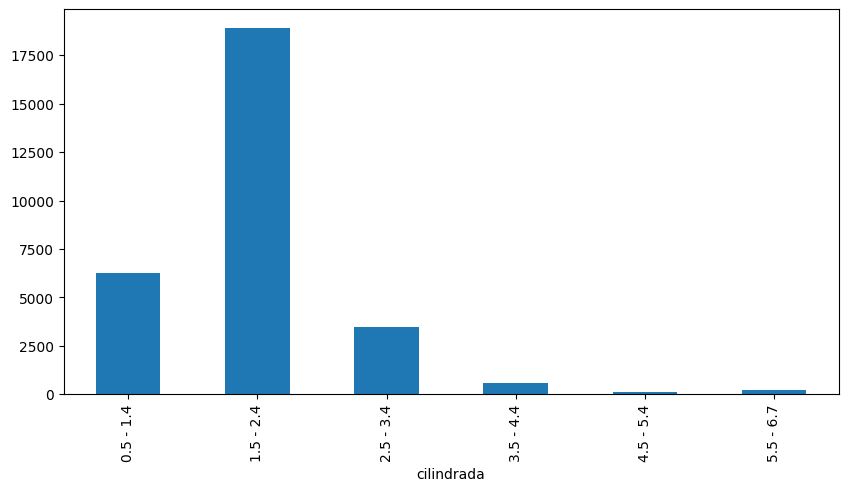

In [325]:
df_cars_train.groupby(df_cars_train['cilindrada']).size().plot(figsize=(10,5), kind='bar')

In [ ]:
# ['ano_de_fabricacao']
# Não há valores NaN na coluna ano_de_fabricacao. Trata-se de uma variável categórica ordinal. Pois é provável que anos mais 
# recentes impliquem um 'preco' maior.

# Visualização da distribuição ['ano_de_fabricacao']
df_cars_train.groupby(df_cars_train['ano_de_fabricacao']).size().plot(kind='bar')

# A distribuição da variável é relativamente regular. Embora o número de categoria seja um pouco extenso.

<Axes: xlabel='ano_modelo'>

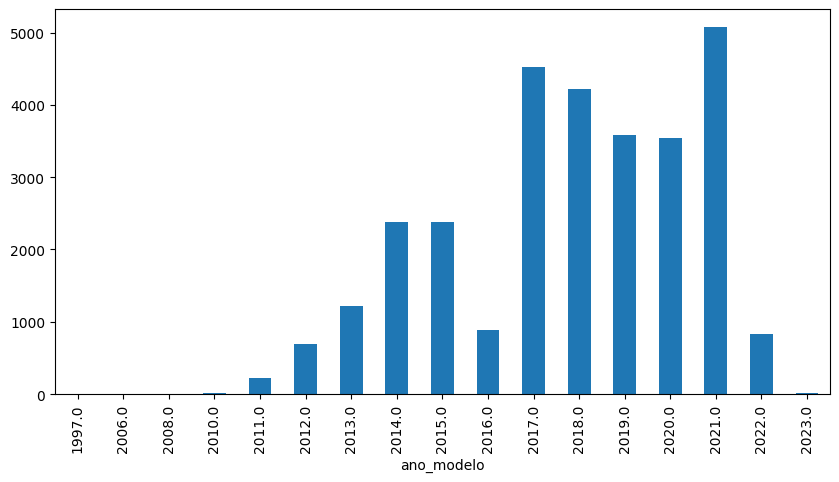

In [322]:
# ['ano_modelo']
# Tal como na coluna 'ano_de_fabricacao', não há valores NaN e trata-se de uma variável categórica ordinal.

# Visualização da distribuição ['ano_modelo']
df_cars_train.groupby(df_cars_train['ano_modelo']).size().plot(figsize=(10,5), kind='bar')

# A distribuição da variável é regular. É um sinal positivo.

In [301]:
# Há, no entanto, muita incoerência entre ano_de_fabricacao e ano_modelo. O código abaixo mostra a incoerência em 17465 linhas.

anos_incoerentes = 0
ano_fabricacao = np.array(df_cars_train['ano_de_fabricacao'])
ano_modelo = np.array(df_cars_train['ano_modelo'])
for i in range(len(ano_fabricacao)):
    if ano_fabricacao[i] != ano_modelo[i]:
        if ano_fabricacao[i] != (ano_modelo[i] + 1):
            anos_incoerentes += 1
print(anos_incoerentes)

# Se observarmos alguns exemplos de anos de fabricação mais antigos, é possível perceber que a incoerência se encontra sobretudo 
# nessa variável. Pois o hodometro indica valores mais coerentes com o ano_modelo.
anos_fabricacao = df_cars_train['ano_de_fabricacao'].unique().tolist()
anos_fabricacao.sort()
for i in range(0,4):
    df_anos = df_cars_train[df_cars_train['ano_de_fabricacao'] == anos_fabricacao[i]]
    print(df_anos[['ano_de_fabricacao', 'ano_modelo', 'hodometro']])

# Por essa razão, a variável 'ano_de_fabricacao' será removida.
df_cars_train.drop(['ano_de_fabricacao'], axis=1, inplace=True)

17465
     ano_de_fabricacao  ano_modelo  hodometro
590               1985      2013.0   192182.0
       ano_de_fabricacao  ano_modelo  hodometro
13276               1988      2011.0   163780.0
19658               1988      2011.0     3548.0
       ano_de_fabricacao  ano_modelo  hodometro
1156                1990      2013.0   171889.0
2032                1990      2010.0   146304.0
18397               1990      2013.0   188389.0
20366               1990      2012.0   106774.0
       ano_de_fabricacao  ano_modelo  hodometro
4960                1991      2013.0   376712.0
11189               1991      2013.0    85559.0
11965               1991      2012.0   104832.0
11985               1991      2012.0   118335.0
17553               1991      2013.0    84628.0
17584               1991      2012.0   152176.0
20958               1991      2013.0   110803.0
22521               1991      2011.0   111190.0
22576               1991      2013.0   166689.0
23872               1991      2013.0  

<Axes: >

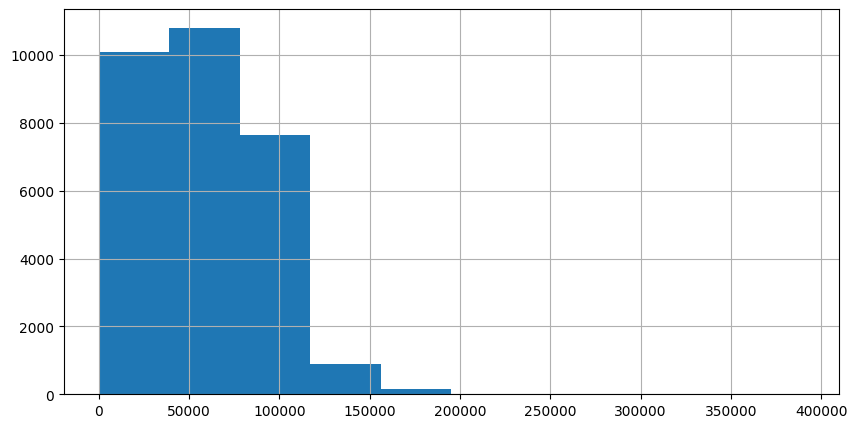

In [327]:
# ['hodometro']
# Não possui valores NaN. Trata-se de uma variável quantitativa e provavelmente tem relação com a variável target.

# Visualização da distribuição ['hodometro']
df_cars_train['hodometro'].hist(figsize=(10,5))

# Não há presença de outliers no histograma do 'hodometro'. É um sinal positivo para o aprendizado de máquina.


<Axes: xlabel='cambio'>

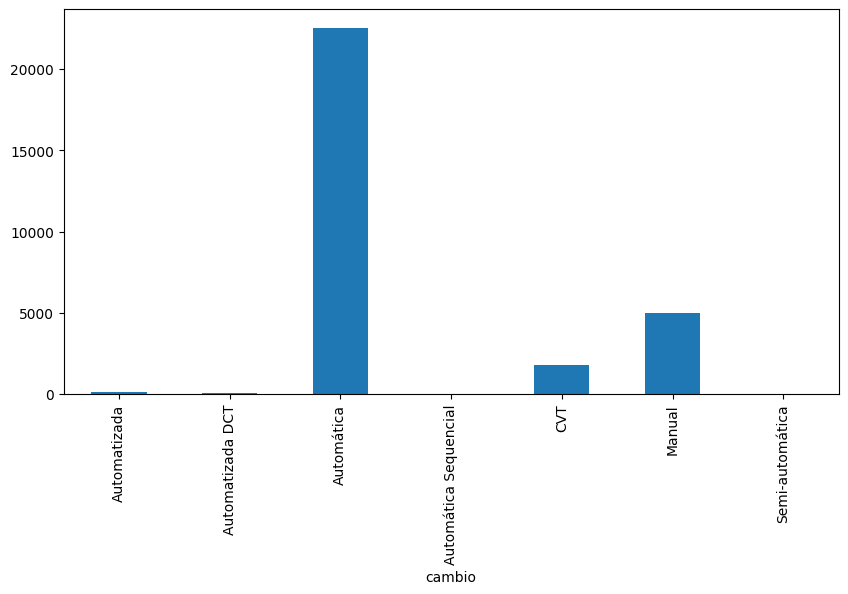

In [326]:
# ['cambio']
# Não possui valores NaN. Trata-se de uma variável categórica com 7 categorias.

# Visualização da distribuição ['cambio']
df_cars_train.groupby(df_cars_train['cambio']).size().plot(figsize=(10,5), kind='bar')

# A distribuição é bastante irregular, o que constitui uma indicação negativa para o aprendizado de máquina. 

In [ ]:
# ['num_portas']
# Não possui valores NaN. Trata-se de uma variável quantitativa discreta. Por conta do número de alternativas (3), será tratada 
# como uma variável categórica.

# Visualização da distribuição ['num_portas']
df_cars_train.groupby(df_cars_train['num_portas']).size().plot(kind='bar')

# A distribuição é bastante irregular, o que constitui uma indicação negativa para o aprendizado de máquina. 

In [ ]:
# ['tipo']
# Não possui valores NaN. Trata-se de uma variável categórica com 7 categorias.

# Visualização da distribuição ['tipo']
df_cars_train.groupby(df_cars_train['tipo']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

In [ ]:
# ['blindado']
# Não possui valores NaN. Trata-se de uma variável categórica booleana com valores 'N' e 'S'. Serão trocados por 'Não' e 'Sim' 
# para facilitar a visualização.

df_cars_train['blindado'].replace('N', 'Não', inplace=True)
df_cars_train['blindado'].replace('S', 'Sim', inplace=True)

# Visualização da distribuição ['blindado']
df_cars_train.groupby(df_cars_train['blindado']).size().plot(kind='bar')

# A distribuição é bastante irregular, o que constitui uma indicação negativa para o aprendizado de máquina.

In [ ]:
# ['cor']
# Não possui valores NaN. Trata-se de uma variável categórica com 7 categorias.

# Visualização da distribuição ['cor']
df_cars_train.groupby(df_cars_train['cor']).size().plot(kind='bar')

# A distribuição é relativamente irregular, o que constitui uma indicação negativa para o aprendizado de máquina.

In [ ]:
# ['tipo_vendedor']
# Não possui valores NaN. Trata-se de uma variável categórica com 2 categorias.

# Visualização da distribuição ['tipo_vendedor']
df_cars_train.groupby(df_cars_train['tipo_vendedor']).size().plot(kind='bar')

# A distribuição é bastante regular, o que constitui uma indicação positiva para o aprendizado de máquina.

Percentual de linhas com incosistência entre cidade e estado:  26.33 %


<Axes: xlabel='estado_vendedor'>

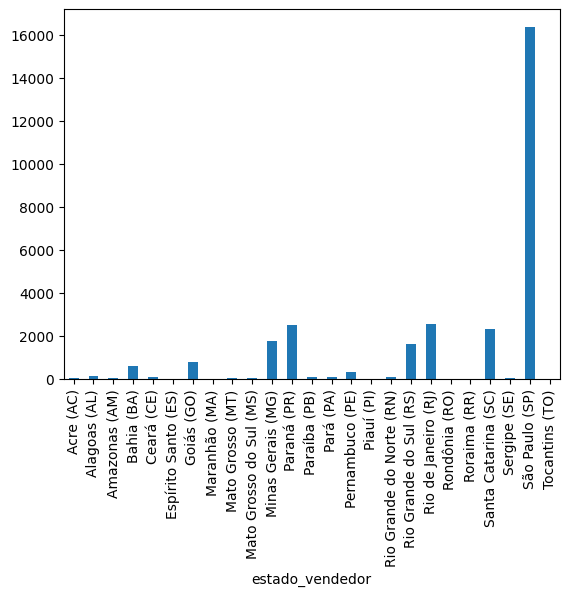

In [302]:
# ['cidade_vendedor'] e ['estado_vendedor']
# Ambas as colunas não possuem valores NaN e contém variáveis categóricas. Há, no entanto, problemas de coerência entre 
# as duas colunas. O código abaixo compara seus valores com um arquivo .csv do governo federal que contém os nomes de todos os 
# municípios do Brasil e seus respectivos estados. O resultado mostra que 26.33% das entradas possuem problemas na relação entre 
# as duas colunas. Decidi manter a coluna 'estado_vendedor' porque o desafio Indicium possui questões a respeito dessa coluna. Em 
# outros contextos, talvez fosse mais interessante manter a coluna 'cidade_vendedor'.

# Formatando colunas cidade e estado para comparação
df_local = pd.DataFrame(df_cars_train[['cidade_vendedor','estado_vendedor']])
df_local['cidade_vendedor'] = df_local['cidade_vendedor'].str.replace(' ', '').str.lower()
for i in range(len(df_local)):
    estado = (df_local.loc[i, 'estado_vendedor'])    
    sigla = estado[(len(estado) - 3):(len(estado) - 1)].lower()
    (df_local.loc[i, 'estado_vendedor']) = sigla

# Criando e formatando dataframe para comparação (fonte: http://blog.mds.gov.br/redesuas/lista-de-municipios-brasileiros/)
df_municipios = pd.read_csv('Lista_Municípios_com_IBGE_Brasil_Versao_CSV.csv', sep=';', encoding='latin-1')
df_municipios.drop(['ConcatUF+Mun', 'IBGE', 'IBGE7', 'Região',
       'População 2010', 'Porte', 'Capital', 'Unnamed: 9'], axis=1, inplace=True)
df_municipios['UF'] = df_municipios['UF'].str.lower()
df_municipios['Município'] = df_municipios['Município'].str.replace(' ', '').str.lower()

# Comparando os dataframes e descobrindo percentual de linhas com problemas 
counter = 0
for i in range(len(df_local)):
    estado = df_municipios['UF'][df_municipios['Município'] == df_local.loc[i, 'cidade_vendedor']]
    if not df_local.loc[i, 'estado_vendedor'] in estado.to_string():
        counter += 1

print("Percentual de linhas com incosistência entre cidade e estado: ", round((counter / len(df_local) * 100), 2), "%")

# Removendo a coluna ['cidade_vendedor']
df_cars_train.drop('cidade_vendedor', axis=1, inplace=True)

# Visualização da distribuição ['estado_vendedor']
df_cars_train.groupby(df_cars_train['estado_vendedor']).size().plot(kind='bar')

# A distribuição é bastante irregular, o que constitui uma indicação negativa para o aprendizado de máquina.

In [ ]:
# ['anunciante']
# Não possui valores NaN. Trata-se de uma variável categórica com 4 categorias.

# Visualização da distribuição ['anunciante']
df_cars_train.groupby(df_cars_train['anunciante']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

In [ ]:
# ['entrega_delivery']
# Não possui valores NaN. Trata-se de uma variável categórica booleana com valores 'False' e 'True'. Serão alterados para 
# 'Não entrega' e 'Entrega' para a visualização

df_cars_train['entrega_delivery'] = df_cars_train['entrega_delivery'].map({True: 'Entrega', False: 'Não entrega'})

# Visualização da distribuição ['entrega_delivery']
df_cars_train.groupby(df_cars_train['entrega_delivery']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

In [ ]:
# ['troca']
# Não possui valores NaN. Trata-se de uma variável categórica booleana com valores 'False' e 'True'. Serão alterados para 
# 'Não foi trocado' e 'Trocado' para a visualização. 

df_cars_train['troca'] = df_cars_train['troca'].map({True: 'Trocado', False: 'Não foi trocado'})

# Visualização da distribuição ['troca']
df_cars_train.groupby(df_cars_train['troca']).size().plot(kind='bar')

# A distribuição é relativamente irregular, o que constitui uma indicação negativa para o aprendizado de máquina.

In [26]:
# ['elegivel_revisao']
# Não possui valores NaN. Todas as entradas são 'False'. A informação se perdeu ou nunca foi preenchida. A coluna não tem serventia
# e será, portanto, excluída.

df_cars_train.drop('elegivel_revisao', axis=1, inplace=True)

In [ ]:
# ['dono_aceita_troca']
# Possui 7662 valores NaN. O valor das demais entradas é 'Aceita troca'. Os valores NaN serão substituídos por 'Não Aceita' para 
# a visualização.

df_cars_train['dono_aceita_troca'].fillna(value='Não aceita', inplace=True)

# Visualização da distribuição ['dono_aceita_troca']
df_cars_train.groupby(df_cars_train['dono_aceita_troca']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

In [ ]:
# ['veiculo_único_dono']
# Possui 19161 valores NaN. O valor das demais entradas é 'Único dono'. Os valores NaN serão substituídos por 'Não' para 
# a visualização.

df_cars_train['veiculo_único_dono'].fillna(value='Não', inplace=True)

# Visualização da distribuição ['veiculo_único_dono']
df_cars_train.groupby(df_cars_train['veiculo_único_dono']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

In [ ]:
# ['revisoes_concessionaria']
# Possui 20412 valores NaN. O valor das demais entradas é 'Todas as revisões feitas pela concessionária'. Os valores NaN 
# serão substituídos por 'Não' e os demais por 'Sim' para facilitar a visualização.

df_cars_train['revisoes_concessionaria'].fillna(value='Não', inplace=True)
df_cars_train['revisoes_concessionaria'].replace('Todas as revisões feitas pela concessionária', 'Sim', inplace=True)

# Visualização da distribuição ['revisoes_concessionaria']
df_cars_train.groupby(df_cars_train['revisoes_concessionaria']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

In [ ]:
# ['ipva_pago']
# Possui 9925 valores NaN. O valor das demais entradas é 'IPVA pago'. Os valores NaN serão substituídos por 'Não' e 
# os demais por 'Pago' para facilitar a visualização.

df_cars_train['ipva_pago'].fillna(value='Não', inplace=True)
df_cars_train['ipva_pago'].replace('IPVA pago', 'Pago', inplace=True)

# Visualização da distribuição ['ipva_pago']
df_cars_train.groupby(df_cars_train['ipva_pago']).size().plot(kind='bar')

# A distribuição é relativamente regular, o que constitui uma indicação positiva para o aprendizado de máquina.

<Axes: xlabel='veiculo_licenciado'>

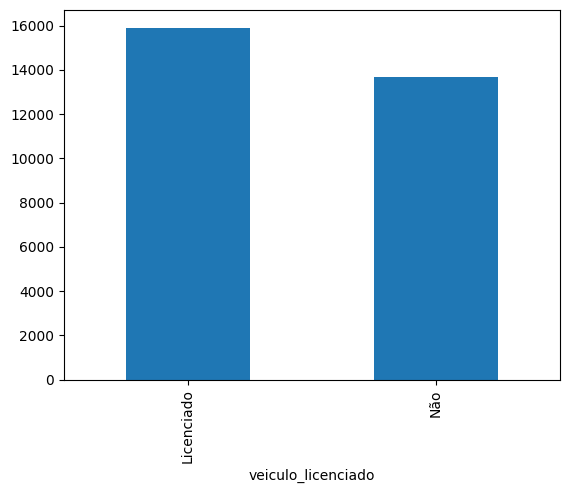

In [31]:
# ['veiculo_licenciado']
# Possui 13678 valores NaN. O valor das demais entradas é 'Licenciado'. Os valores NaN serão substituídos por 'Não'para 
# facilitar a visualização.

df_cars_train['veiculo_licenciado'].fillna(value='Não', inplace=True)

# Visualização da distribuição ['veiculo_licenciado']
df_cars_train.groupby(df_cars_train['veiculo_licenciado']).size().plot(kind='bar')

# A distribuição é bastante regular, o que constitui uma indicação positiva para o aprendizado de máquina.

<Axes: xlabel='garantia_de_fábrica'>

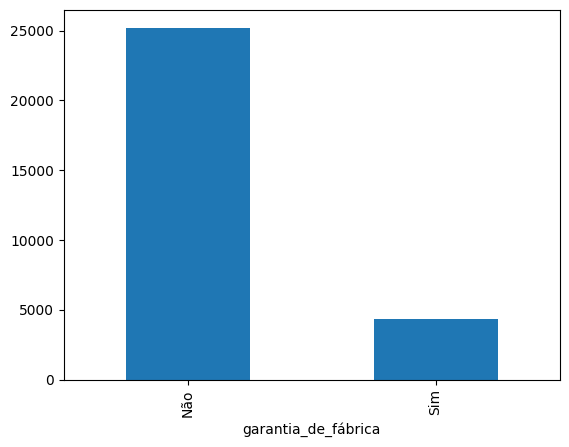

In [32]:
# ['garantia_de_fábrica']
# Possui 25219 valores NaN. O valor das demais entradas é 'Garantia de fábrica'. Os valores NaN serão substituídos por 'Não' e 
# os demais valores por 'Sim' para facilitar a visualização.
df_cars_train['garantia_de_fábrica'].fillna(value='Não', inplace=True)
df_cars_train['garantia_de_fábrica'].replace('Garantia de fábrica', 'Sim', inplace=True)

# Visualização da distribuição ['garantia_de_fábrica']
df_cars_train.groupby(df_cars_train['garantia_de_fábrica']).size().plot(kind='bar')

# A distribuição é relativamente irregular, o que constitui uma indicação negativa para o aprendizado de máquina.

<Axes: xlabel='revisoes_dentro_agenda'>

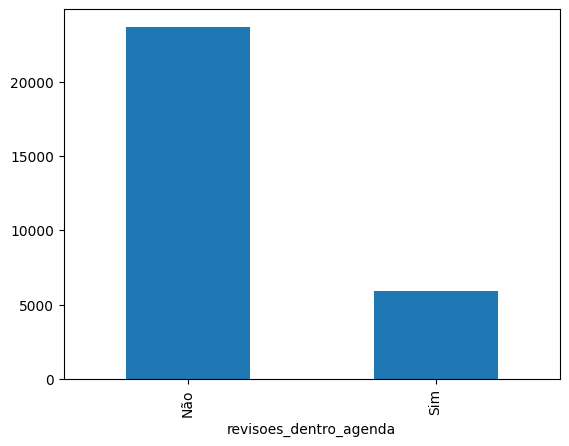

In [33]:
# ['revisoes_dentro_agenda']
# Possui 23674 valores NaN. O valor das demais entradas é 'Todas as revisões feitas pela agenda do carro'. Os valores 
# NaN serão substituídos por 'Não' e os demais valores por 'Sim' para facilitar a visualização.
df_cars_train['revisoes_dentro_agenda'].fillna(value='Não', inplace=True)
df_cars_train['revisoes_dentro_agenda'].replace('Todas as revisões feitas pela agenda do carro', 'Sim', inplace=True)

# Visualização da distribuição ['revisoes_dentro_agenda']
df_cars_train.groupby(df_cars_train['revisoes_dentro_agenda']).size().plot(kind='bar')

# A distribuição é relativamente irregular, o que constitui uma indicação negativa para o aprendizado de máquina.

In [34]:
# ['veiculo_alienado']
# Possui apenas valores NaN. A coluna não tem serventia e será, portanto, excluída.
df_cars_train.drop('veiculo_alienado', axis=1, inplace=True)

In [35]:
# ['preco']
# A coluna 'preco' não possui valores NaN e é uma variável quantitativa. É a variável target do nosso modelo.

In [36]:
# Visualizando as informações básicas do conjunto de dados APÓS o primiero tratamento
print(df_cars_train.info())
print(df_cars_train.nunique())
print(df_cars_train.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_fotos                29584 non-null  float64
 1   marca                    29584 non-null  object 
 2   modelo                   29584 non-null  object 
 3   cilindrada               29584 non-null  object 
 4   tipo_combustivel         29584 non-null  object 
 5   ano_modelo               29584 non-null  float64
 6   hodometro                29584 non-null  float64
 7   cambio                   29584 non-null  object 
 8   num_portas               29584 non-null  int64  
 9   tipo                     29584 non-null  object 
 10  blindado                 29584 non-null  object 
 11  cor                      29584 non-null  object 
 12  tipo_vendedor            29584 non-null  object 
 13  estado_vendedor          29584 non-null  object 
 14  anunciante            

In [41]:
# Respondendo a questão 1.
# Se for a marca mais popular 
# Primeiro, selecionarei as 5 marcas que possuem o maior número de entradas no conjunto de dados. Elas são consideradas as mais 
# populares. Criarei uma lista com os estados também.
marcas_populares = df_cars_train['marca'].value_counts().keys().tolist()[0:5]
estados = df_cars_train['estado_vendedor'].value_counts().keys().tolist()

# Segundo, somarei a média de preço de cada um dessas marcas por estado. 
estados_media_populares = []
for estado in estados:
    media_estado = 0
    df_estado = df_cars_train[df_cars_train['estado_vendedor'] == estado]
    for marca in marcas_populares:
        df_marca = df_estado[df_estado['marca'] == marca]
        media_estado += df_marca['preco'].mean()
    estados_media_populares.append(media_estado / len(marcas_populares))

# Terceiro, selecionarei o maior valor médio de carro de marca popular entre os valores dos estados
print('Maior preço médio de um carro de marca popular é o do estado de', estados[estados_media_populares.index(max(estados_media_populares))],
      ': R$', round(max(estados_media_populares), 2))

# Quarto, a resposta é Goiás. O preço médio de um carro de marca popular em Goiás é o maior de todos os estados do Brasil. 
# Portanto, é o melhor estado para se vender um carro de marca popular.

Maior preço médio de um carro de marca popular é o do estado de Goiás (GO) : R$ 134465.97


In [42]:
# Respondendo a questão 1 NOVAMENTE.
# Se for o modelo mais popular
modelos_populares = df_cars_train['modelo'].value_counts().keys().tolist()[0:10]
estados = df_cars_train['estado_vendedor'].value_counts().keys().tolist()

estados_media_populares = []
for estado in estados:
    media_estado = 0
    df_estado = df_cars_train[df_cars_train['estado_vendedor'] == estado]
    for modelo in modelos_populares:
        df_modelo = df_estado[df_estado['modelo'] == modelo]
        media_estado += df_modelo['preco'].mean()
    estados_media_populares.append(media_estado / len(modelos_populares))

print('Maior preço médio de um carro de modelo popular é o do estado de', estados[estados_media_populares.index(max(estados_media_populares))],
      ': R$', round(max(estados_media_populares), 2))

Maior preço médio de um carro de modelo popular é o do estado de Goiás (GO) : R$ 158176.07


In [43]:
# Respondendo a questão 2:
# Primeiro, selecionarei as entradas das picapes com transmissão automática.
picapes = df_cars_train[df_cars_train['tipo'] == 'Picape']
picapes_automaticas = picapes[picapes['cambio'] == 'Automática']

# Segundo, selecionarei a média de preço das picapes por estado:
estados_media_picapes_automaticas = []
for estado in estados:
    media_estado = 0
    df_estado = picapes_automaticas[picapes_automaticas['estado_vendedor'] == estado]
    media_estado = df_estado['preco'].mean()
    estados_media_picapes_automaticas.append(media_estado)
    
# Terceiro, selecionarei o menor preço médio de picape entre os estados
print('Menor preço médio de uma picape com transmissão automática é o do estado de', estados[estados_media_picapes_automaticas.index(min(
    estados_media_picapes_automaticas))],': R$', round(min(estados_media_picapes_automaticas), 2))

# Quarto, a resposta é Paraíba. O preço médio de uma picape na Paraíba é o menor de todos os estados do Brasil. 
# Portanto, é o melhor estado para se comprar uma picape.

Menor preço médio de uma picape com transmissão automática é o do estado de Paraíba (PB) : R$ 93157.04


In [44]:
# Respondendo a questão 3:
# Primeiro, selecionarei as entradas com carros que ainda possuem a garatina de fábrica
garantidos = df_cars_train[df_cars_train['garantia_de_fábrica'] == 'Sim']

# Segundo, selecionarei a média de preço dos carros com garantia de fábrica por estado:
estados_media_garantidos = []
for estado in estados:
    media_estado = 0
    df_estado = garantidos[garantidos['estado_vendedor'] == estado]
    media_estado = df_estado['preco'].mean()
    estados_media_garantidos.append(media_estado)
    
# Terceiro, selecionarei o menor preço médio dos carros com garantia de fábrica entre os estados
print('Menor preço médio de um carro com garantia de fábrica é o do estado de', estados[estados_media_garantidos.index(min(
    estados_media_garantidos))], ': R$', round(min(estados_media_garantidos), 2))

# Quarto, a resposta é Paraíba. O preço médio de um carro com garantia de fábrica na Paraíba é o menor de todos os estados do Brasil. 
# Portanto, é o melhor estado para se comprar um carro com garantia de fábrica.

Menor preço médio de um carro com garantia de fábrica é o do estado de Paraíba (PB) : R$ 95762.75


In [ ]:
# As três hipóteses de negócio:

# Primeira: o fato do carro ter um único dono influencia significativamente seu preço

# Segunda: o fato do carro ter feito as revisões só na concessionária não influencia significativamente seu preço

# Terceira: o valor do hodometro influencia significativamente o preço do carro.

In [46]:
# Primeira hipótese

# Primeiro, selecionarei os carros que possuem um único dono e usarei o tipo como critério para equilibrar a comparação.
tipos = df_cars_train['tipo'].unique().tolist()

for tipo in tipos:
    df_unico_dono = df_cars_train[(df_cars_train['veiculo_único_dono'] == 'Único dono') & (df_cars_train['tipo'] == tipo)]
    #print(len(df_unico_dono))

    df_multiplos_donos = df_cars_train[(df_cars_train['veiculo_único_dono'] == 'Não') & (df_cars_train['tipo'] == tipo)]
    #print(len(df_multiplos_donos))
    
    diferenca_percentual = (df_unico_dono['preco'].mean() / df_multiplos_donos['preco'].mean()) * 100
    if not np.isnan(diferenca_percentual):
        print('Para ' + tipo + ', a média de preço dos carros de um único dono equivale a '
              + str(round(diferenca_percentual, 2)) + '% do valor médio de preço dos carros de múltiplos donos.')

# A hipótese foi validada. Na maior parte dos casos, o fato de ter um único dono aumenta o preço de carros do mesmo tipo.

Para Sedã, a média de preço dos carros de um único dono equivale a 115.96% do valor médio de preço dos carros de múltiplos donos.
Para Picape, a média de preço dos carros de um único dono equivale a 96.72% do valor médio de preço dos carros de múltiplos donos.
Para Utilitário esportivo, a média de preço dos carros de um único dono equivale a 104.99% do valor médio de preço dos carros de múltiplos donos.
Para Hatchback, a média de preço dos carros de um único dono equivale a 102.94% do valor médio de preço dos carros de múltiplos donos.
Para Cupê, a média de preço dos carros de um único dono equivale a 141.56% do valor médio de preço dos carros de múltiplos donos.
Para Minivan, a média de preço dos carros de um único dono equivale a 153.76% do valor médio de preço dos carros de múltiplos donos.


In [47]:
# Segunda hipótese
# Primeiro, selecionarei os carros que só fizeram revisões na concessionária e possuam hodômetro abaixo de 30000 km. O critério 
# do hodômetro serve ao propósito de equilibrar a comparação.

diferencas_percentuais = []
valores_hodometro = []

for i in range(0, 100000, 20000):
    j = i + 20000
    valores_hodometro.append(i)
    df_revisados = df_cars_train[(df_cars_train['hodometro'] > i) & (df_cars_train['hodometro'] <= (j)) & 
                                 (df_cars_train['revisoes_concessionaria'] == 'Sim')]
    df_nao_revisados = df_cars_train[(df_cars_train['hodometro'] > i) & (df_cars_train['hodometro'] <= (j)) &
                                     (df_cars_train['revisoes_concessionaria'] == 'Não')]
    
    diferencas_percentuais.append(round((1 - (df_revisados['preco'].mean() / df_nao_revisados['preco'].mean())) * -100))
    
print('### Diferença percentual de preço dos carros revisados APENAS na concessionários e carros NÃO revisados APENAS na concessionária ###')

for i in range(len(diferencas_percentuais)):
    print('Entre ', valores_hodometro[i], 'e', (valores_hodometro[i] + 20000), 'km: ', str(diferencas_percentuais[i]) + '%')
    
# A hipótese foi invalidada pelo teste. Na faixa de carros entre 20000 e 40000 km, por exemplo, a média de preços de carros 
# que foram revisados APENAS na concessionária chega a ser 25% maior que a média de preços que NÃO forma revisados APENAS na 
# concessionária.

### Diferença percentual de preço dos carros revisados APENAS na concessionários e carros NÃO revisados APENAS na concessionária ###
Entre  0 e 20000 km:  10%
Entre  20000 e 40000 km:  19%
Entre  40000 e 60000 km:  25%
Entre  60000 e 80000 km:  13%
Entre  80000 e 100000 km:  12%


In [48]:
# Terceira hipótese
# Primeiro, selecionarei as entradas pelos seguintes intervalos de valor da variável hodômetro (0-20K, 20-40K, 40_60K, 60-80K, 
# 80-100K, 100-120K, 120-140K, 140K_). Segundo, selecionarei a médio dos preços por categoria de valores de hodômetro.

valores_hodometro = [0, 20000, 40000, 60000, 80000, 100000,  120000, 140000]

for i in range(len(valores_hodometro)):
    if i < (len(valores_hodometro) - 1):
        nome = 'carros_' + str(round(valores_hodometro[i] / 1000)) + '_' + str(round(valores_hodometro[i+1] / 1000)) + 'K'
        carros = df_cars_train[(df_cars_train['hodometro'] > valores_hodometro[i]) & (df_cars_train['hodometro'] <=
                                                                                      (valores_hodometro[i+1]))]
    else:
        nome = 'carros_' + str(round(valores_hodometro[i] / 1000)) + 'K_'
        carros = df_cars_train[(df_cars_train['hodometro'] > valores_hodometro[i])]
    
    print(nome, ': R$' + str(round(carros['preco'].mean())))

# É possível observar nos resultados que os valores mais baixos de hodômetro correspondem às médias mais altas de preços. Eles 
# comprovam assim a hipótese levantada.


carros_0_20K : R$182781
carros_20_40K : R$160401
carros_40_60K : R$130141
carros_60_80K : R$119030
carros_80_100K : R$111052
carros_100_120K : R$88925
carros_120_140K : R$64578
carros_140K_ : R$54675


In [50]:
#

# Removendo a coluna 'modelo':
df_cars_train.drop(['modelo'], axis=1, inplace=True)

In [52]:
# Análise visual das relações entre as features e o target
# Variáveis quantitativas contínuas:
# 'hodometro'

# Variáveis categóricas
# 'num_fotos', 'marca', 'cilindrada', 'tipo_combustivel', 'ano_modelo', , 'cambio', 'num_portas', 'tipo', 'blindado', 'cor', 'tipo_vendedor', 'estado_vendedor', 'anunciante', 'entrega_delivery', 'troca', 'dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago', 'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda'

24

,hodometro,preco
hodometro,1.000000,-0.359218
preco,-0.359218,1.000000


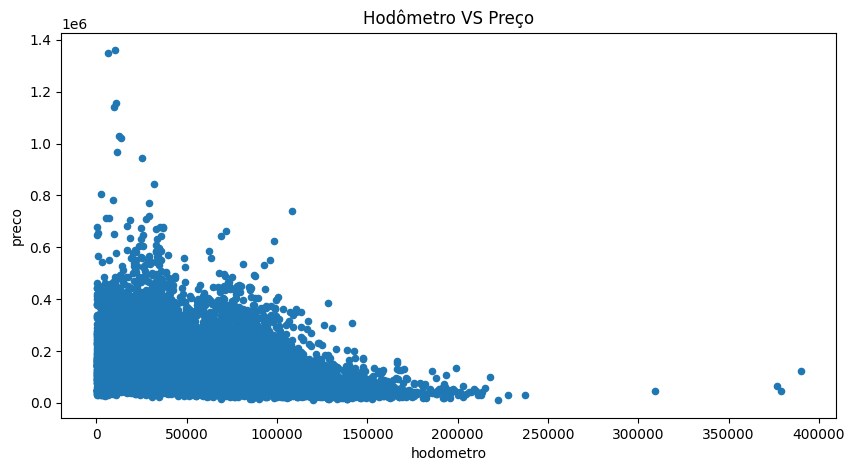

In [328]:
# Variáveis contínuas
# ['hodometro']
df_cars_train.plot.scatter(x='hodometro', y='preco', figsize=(10,5), title='Hodômetro'+" VS "+ 'Preço')
df_cars_train[['hodometro', 'preco']].corr()

# Considera-se que uma correlação abaixo de 0,5, positiva ou negativa, demonstra pouca relação entre as duas variáveis. O que, de 
# certa forma, sugere a exclusão da variável 'hodometro'. O gráfico, no entanto, permite ver uma tendência: quanto maior o 
# hodômetro, menor o preço. Ela será mantida para a aplicação no algoritmo de aprendizado de máquina.

Há correlação entre as duas variáveis.


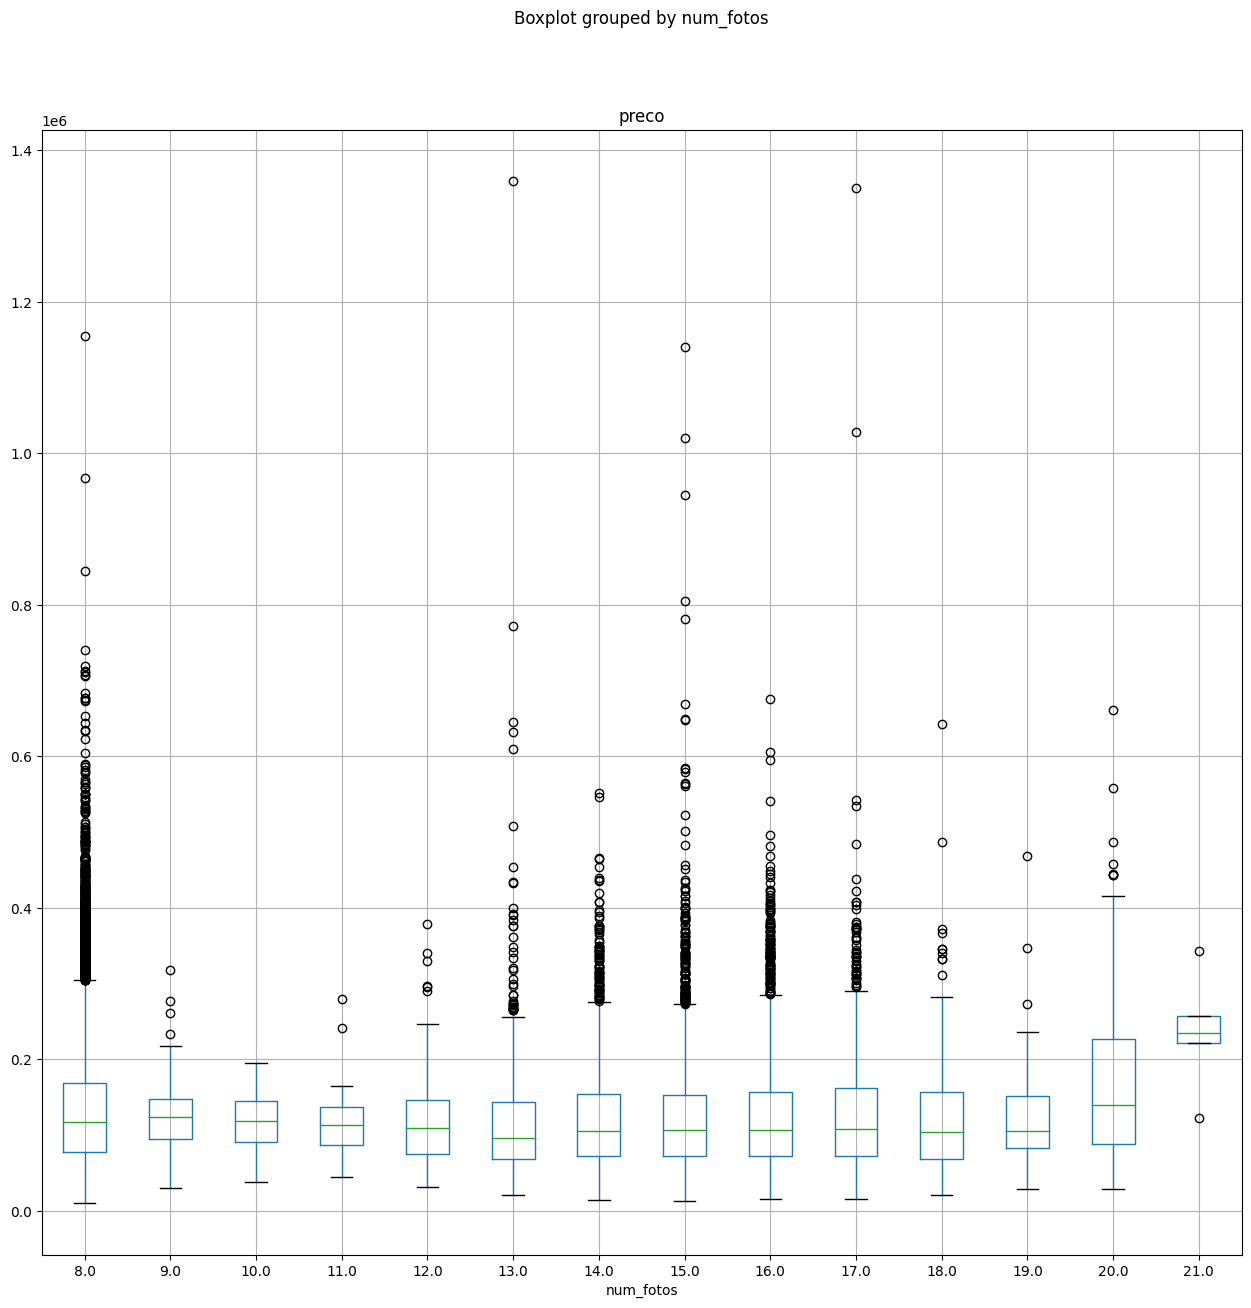

In [66]:
# Variáveis categóricas
# 'num_fotos'
df_cars_train.boxplot(column='preco', by='num_fotos', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('num_fotos')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print("Há correlação entre as duas variáveis.")

0.0
Há correlação entre as duas variáveis.


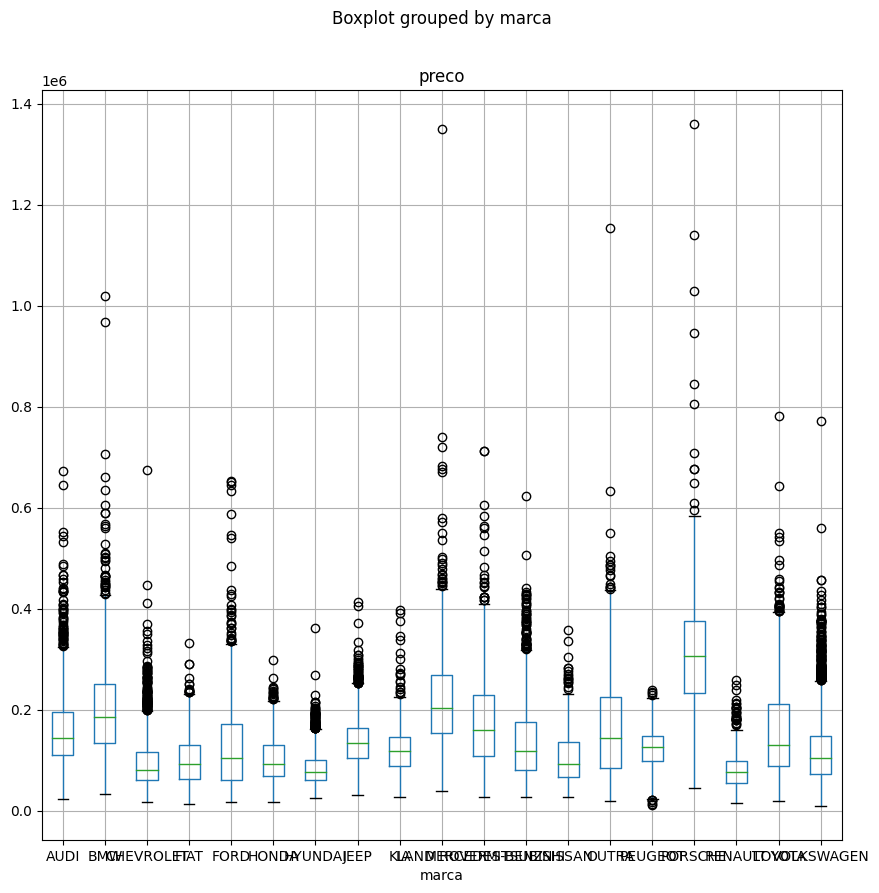

In [335]:
# Variáveis categóricas
# 'marca'
df_cars_train.boxplot(column='preco', by='marca', figsize=(10,10), vert=True)

categorias = df_cars_train.groupby('marca')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

0.0
Há correlação entre as duas variáveis.


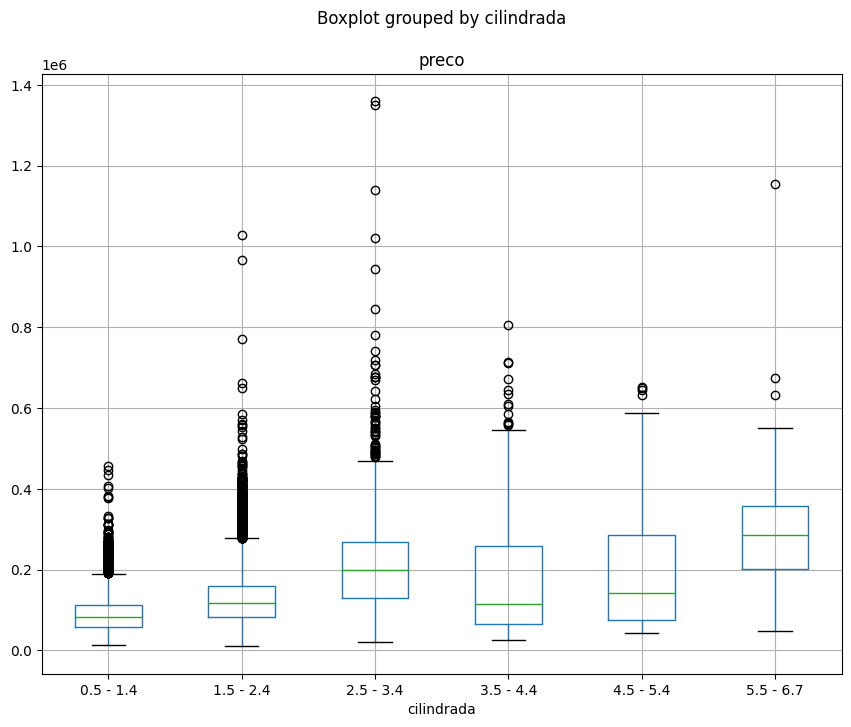

In [331]:
# Variáveis categóricas
# 'cilindrada'
df_cars_train.boxplot(column='preco', by='cilindrada', figsize=(10,8), vert=True)

categorias = df_cars_train.groupby('cilindrada')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

0.0
Há correlação entre as duas variáveis.


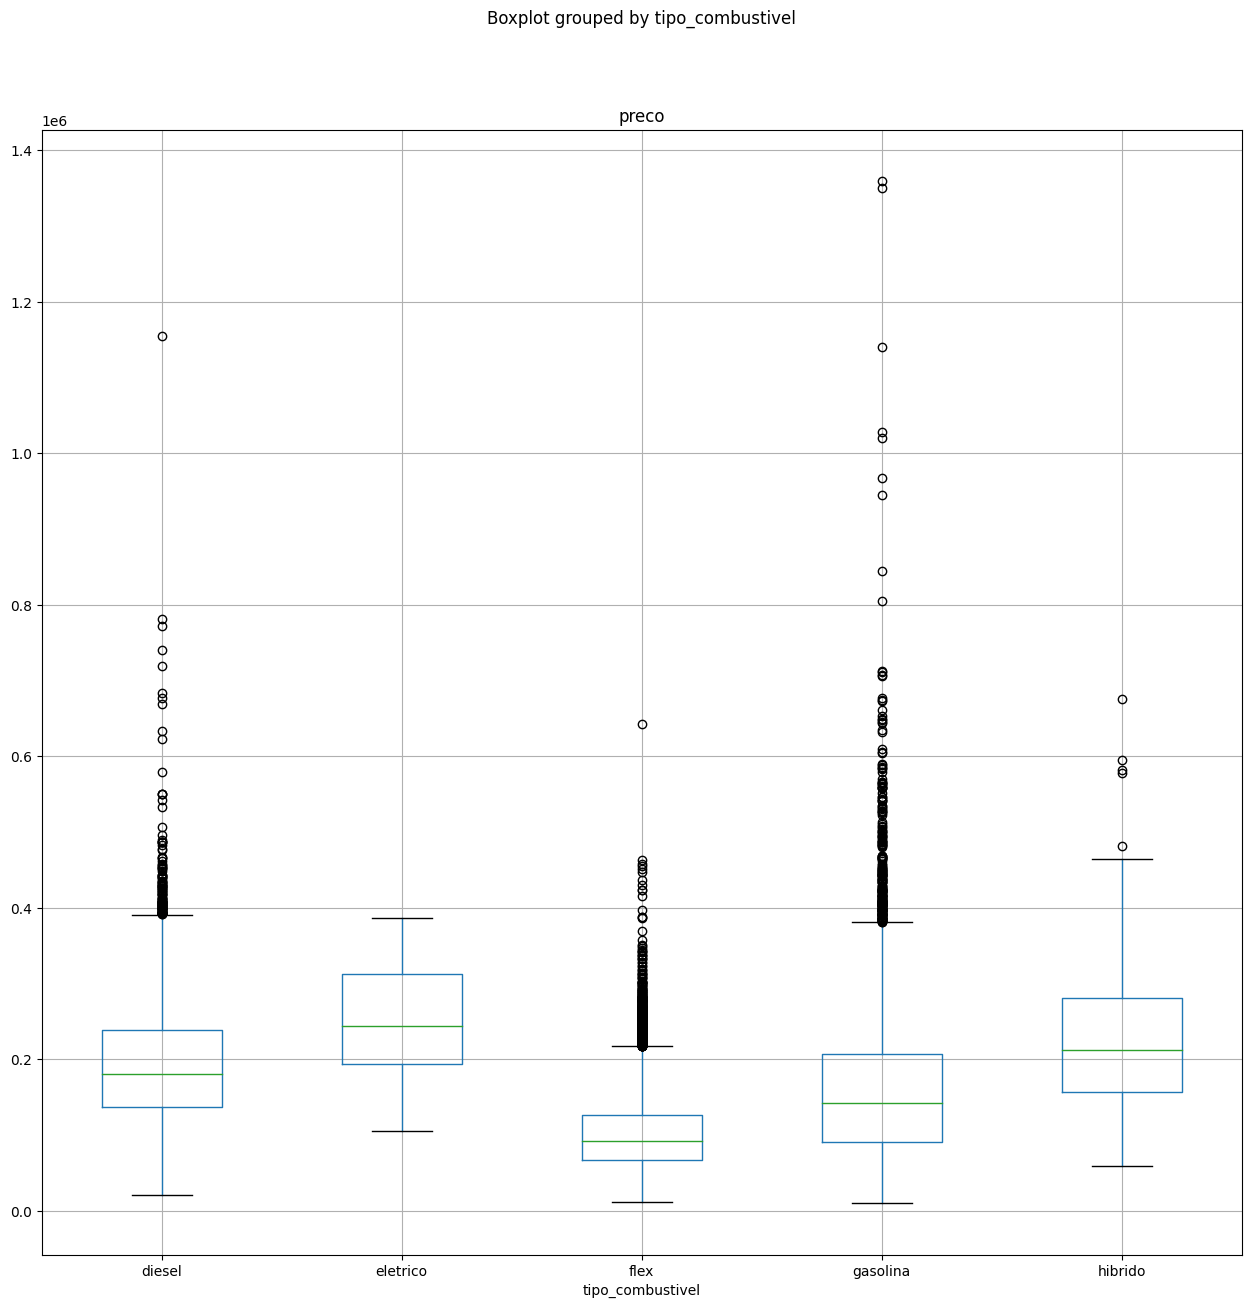

In [73]:
# Variáveis categóricas
# 'tipo_combustivel'
df_cars_train.boxplot(column='preco', by='tipo_combustivel', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('tipo_combustivel')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

0.0
Há correlação entre as duas variáveis.


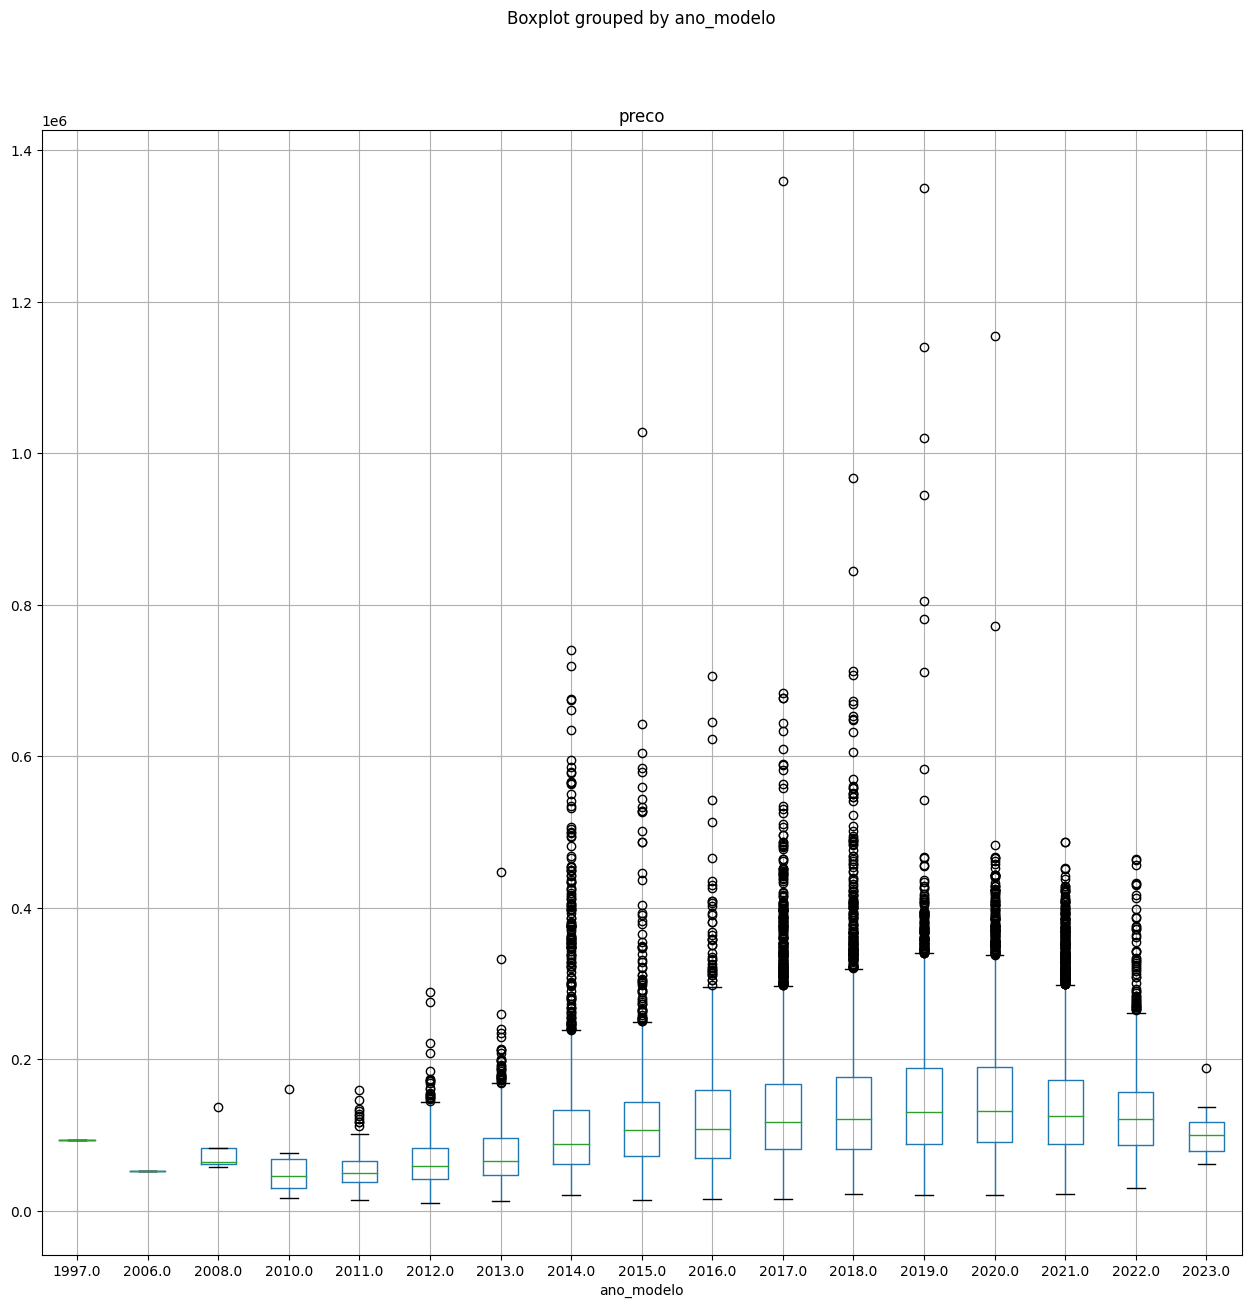

In [74]:
# Variáveis categóricas
# 'ano_modelo'
df_cars_train.boxplot(column='preco', by='ano_modelo', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('ano_modelo')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

0.0
Há correlação entre as duas variáveis.


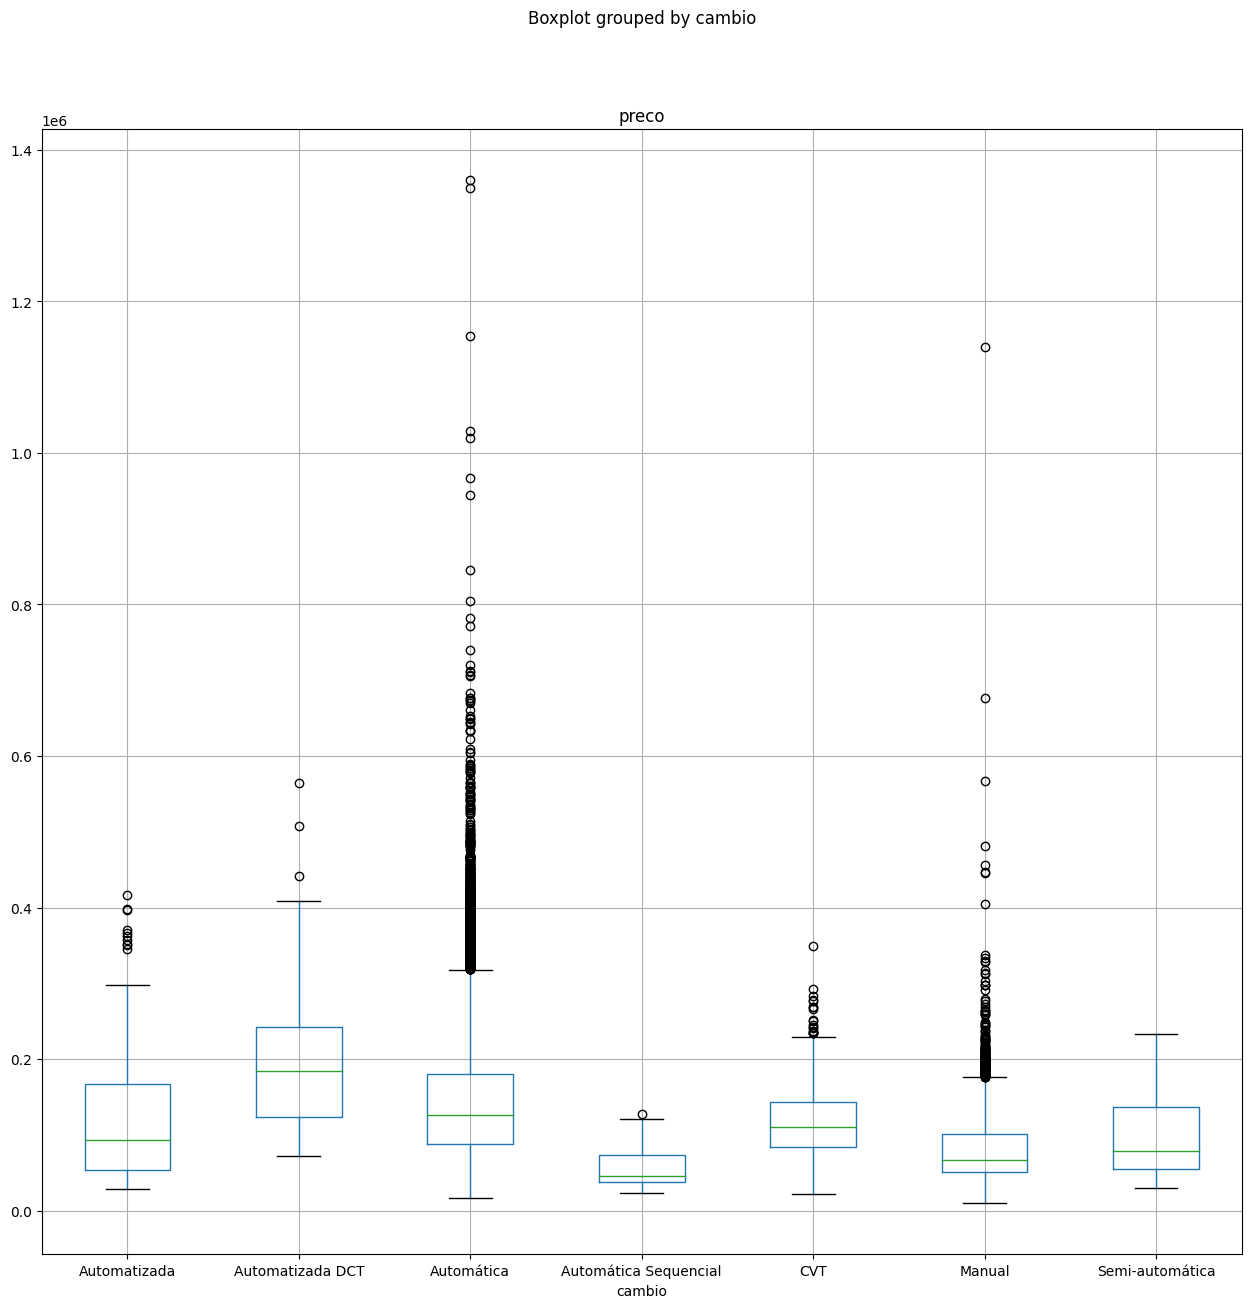

In [75]:
# Variáveis categóricas
# 'cambio'
df_cars_train.boxplot(column='preco', by='cambio', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('cambio')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

3.4028284536488946e-39
Há correlação entre as duas variáveis.


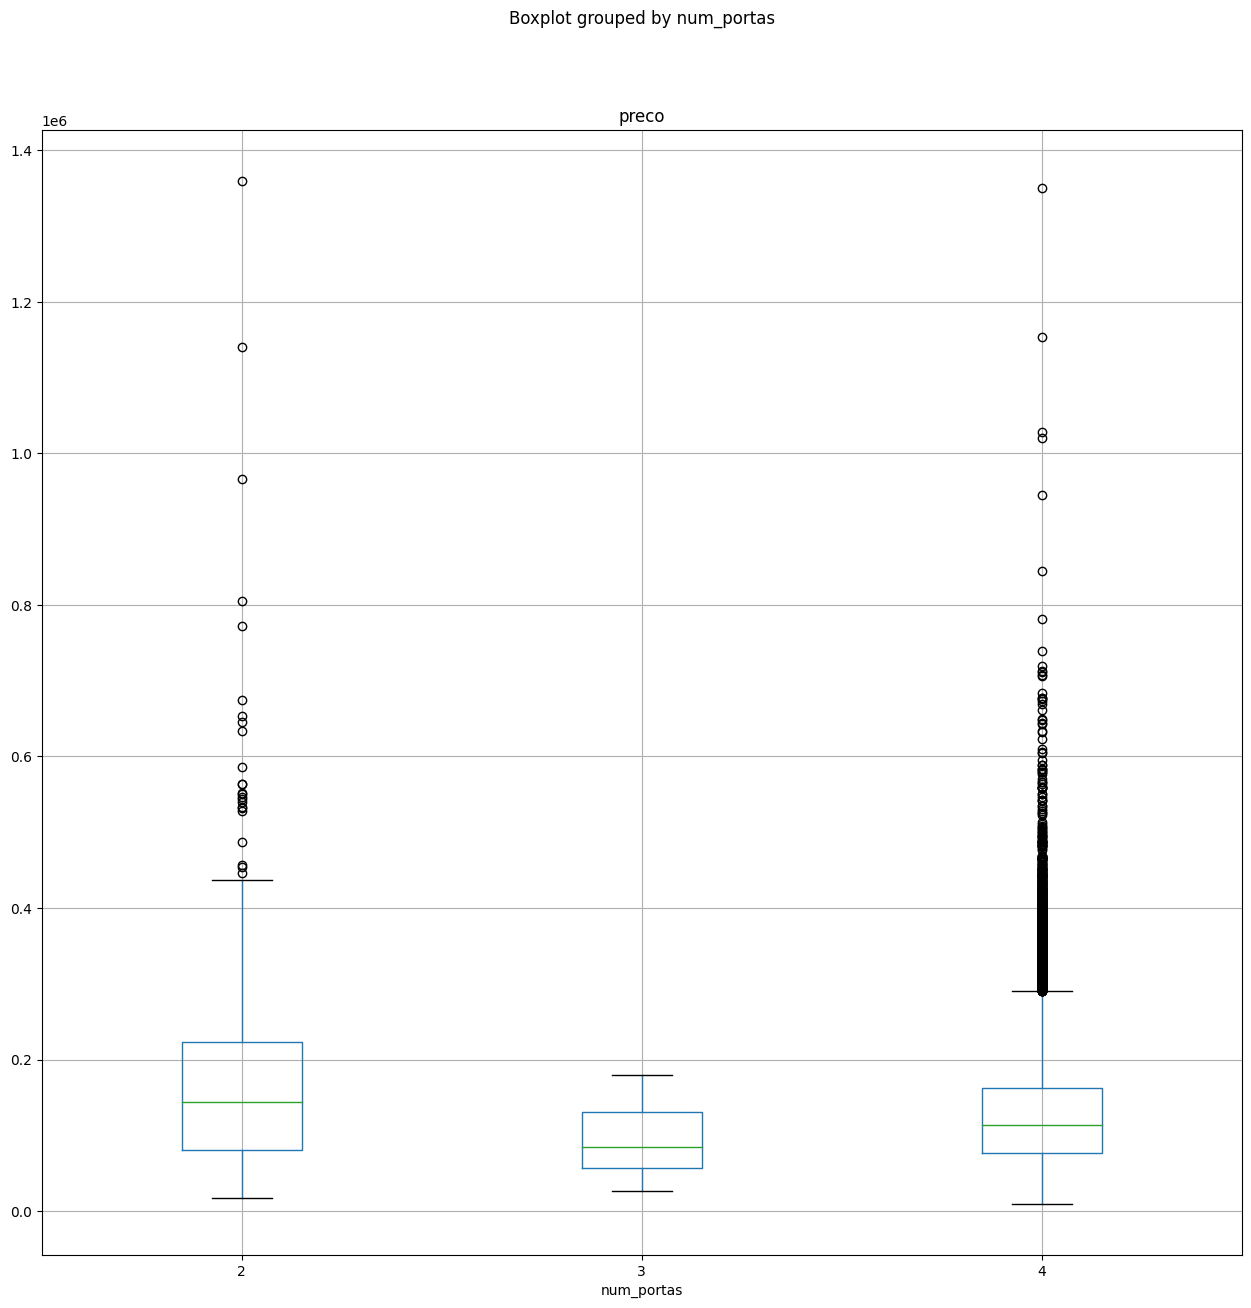

In [76]:
# Variáveis categóricas
# 'num_portas'
df_cars_train.boxplot(column='preco', by='num_portas', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('num_portas')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

0.0
Há correlação entre as duas variáveis.


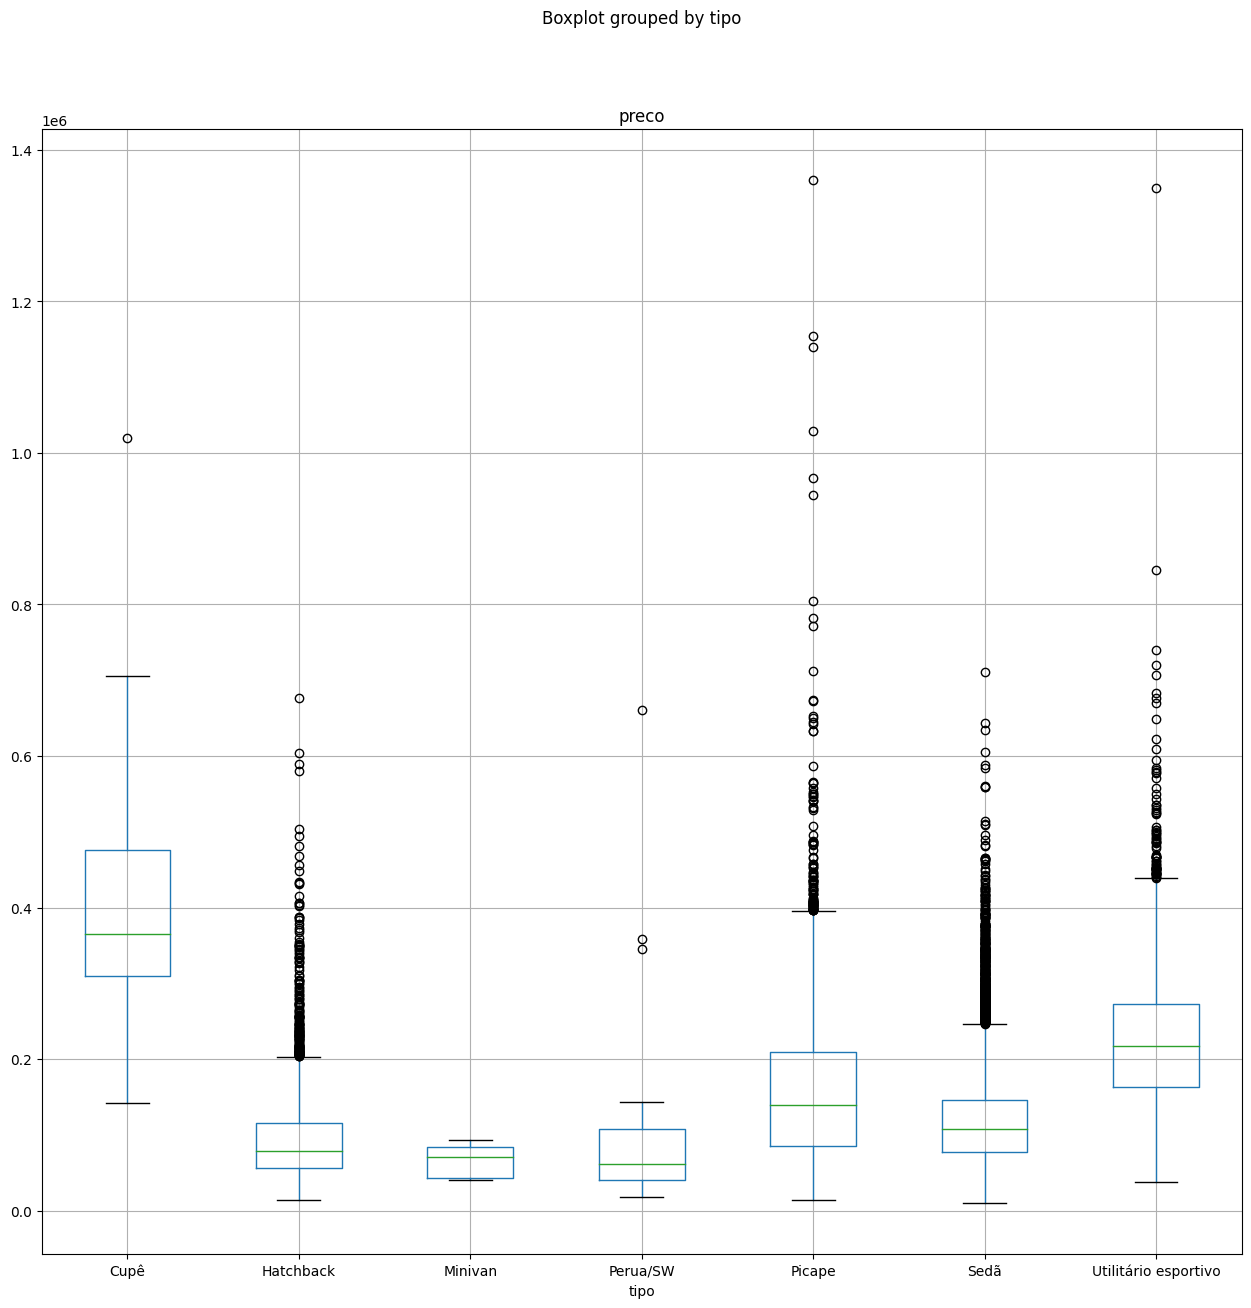

In [77]:
# Variáveis categóricas
# 'tipo'
df_cars_train.boxplot(column='preco', by='tipo', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('tipo')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

1.1790119790198452e-51
Há correlação entre as duas variáveis.


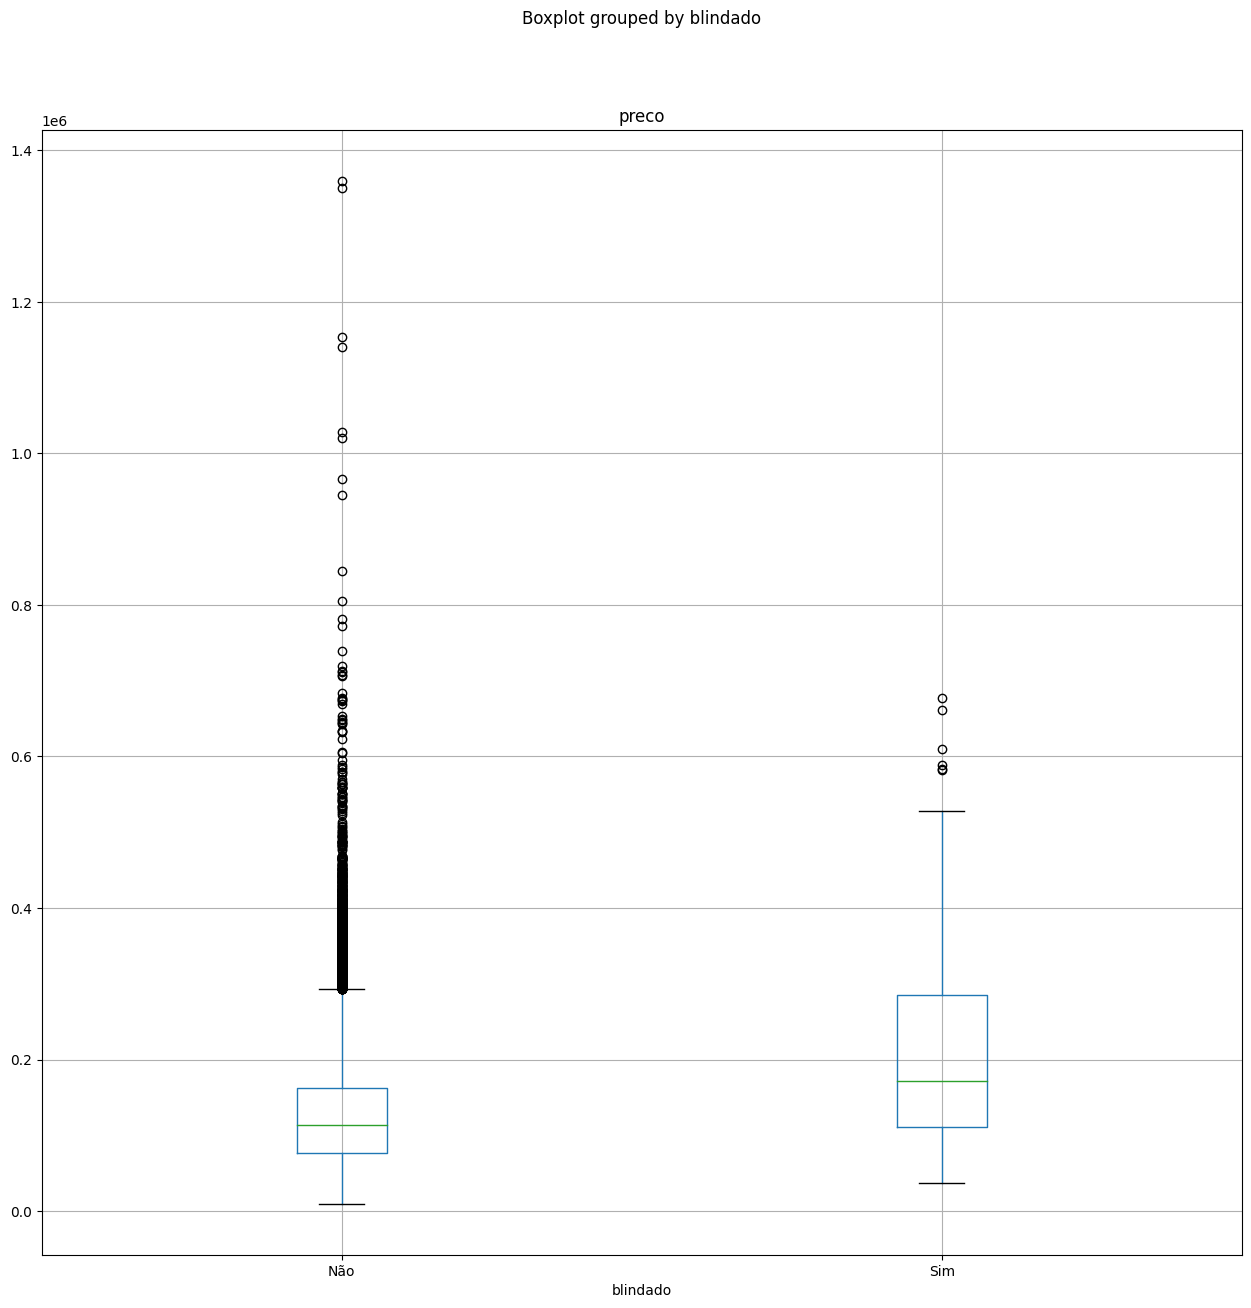

In [78]:
# Variáveis categóricas
# 'blindado'
df_cars_train.boxplot(column='preco', by='blindado', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('blindado')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

5.37256935176686e-309
Há correlação entre as duas variáveis.


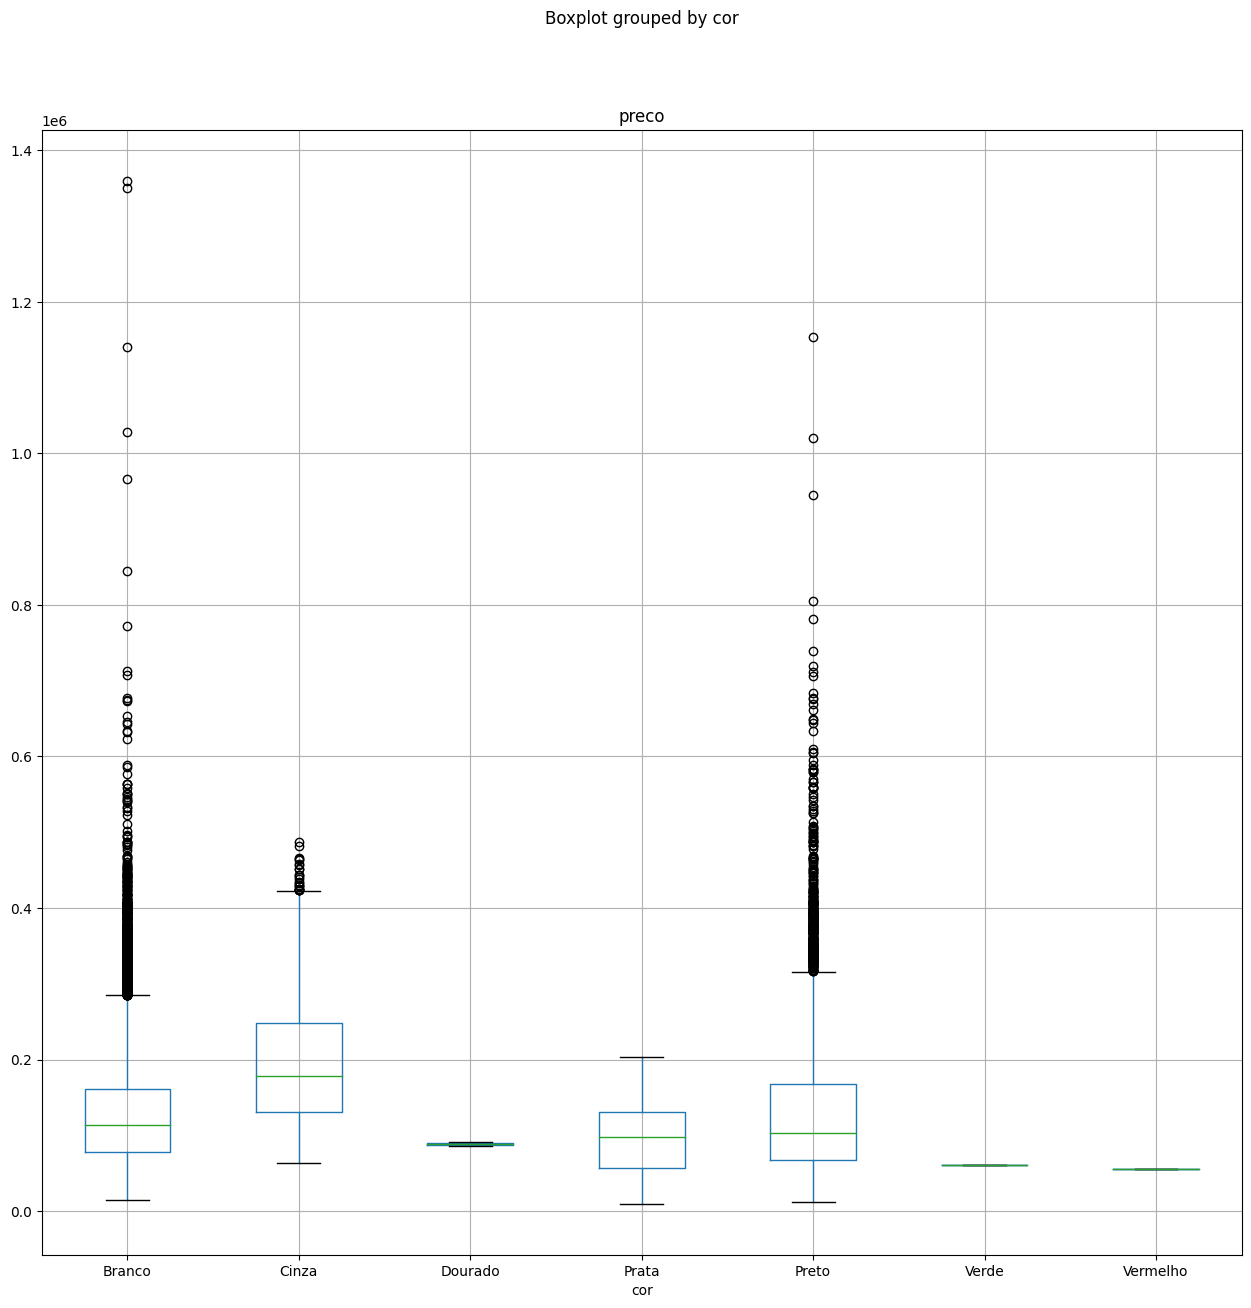

In [79]:
# Variáveis categóricas
# 'cor'
df_cars_train.boxplot(column='preco', by='cor', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('cor')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

1.1552814710117806e-53
Há correlação entre as duas variáveis.


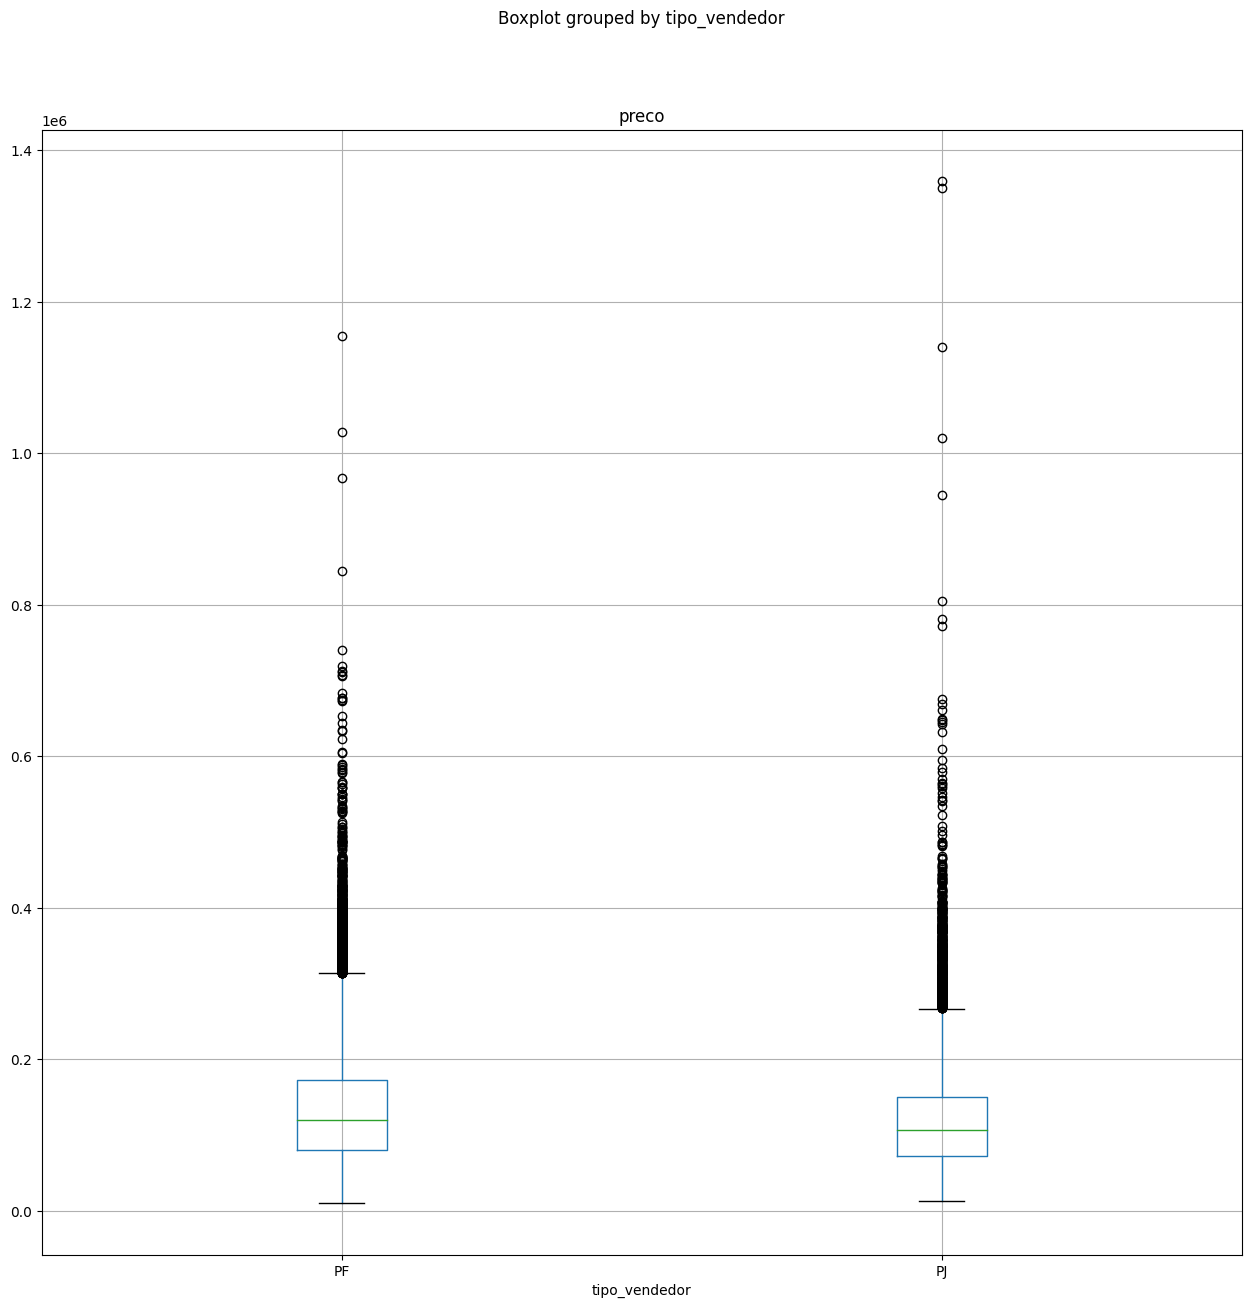

In [80]:
# Variáveis categóricas
# 'tipo_vendedor'
df_cars_train.boxplot(column='preco', by='tipo_vendedor', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('tipo_vendedor')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

1.6927458231812857e-43
Há correlação entre as duas variáveis.


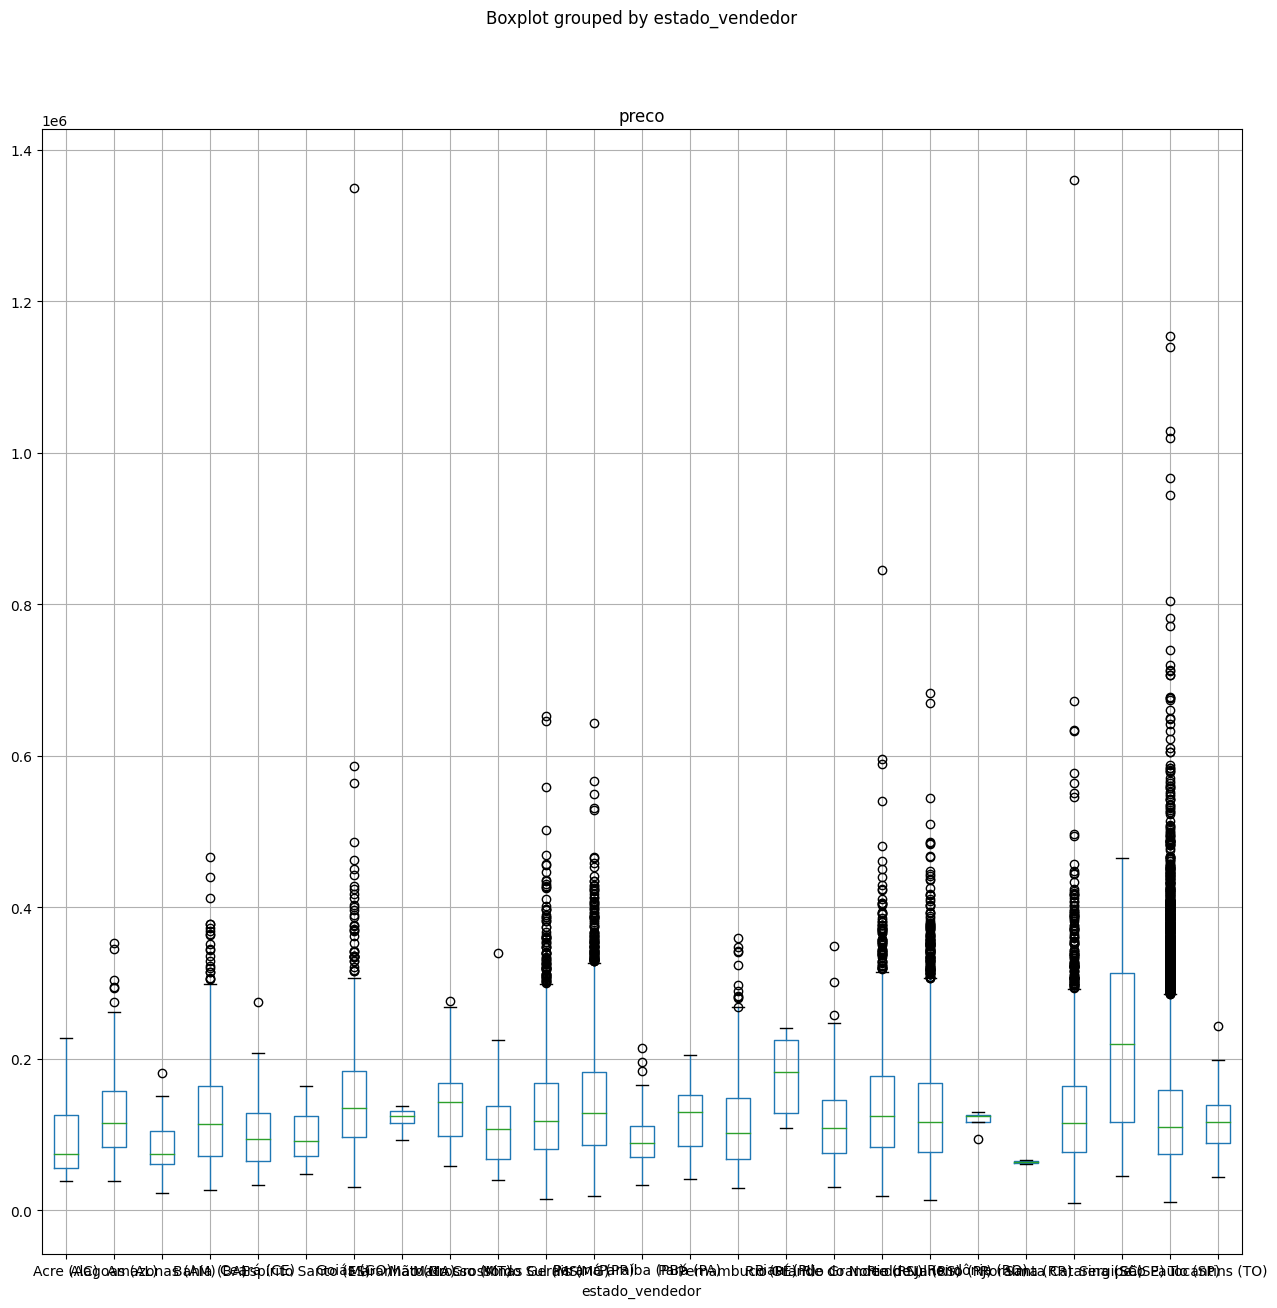

In [81]:
# Variáveis categóricas
# 'estado_vendedor'
df_cars_train.boxplot(column='preco', by='estado_vendedor', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('estado_vendedor')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

6.039276152082744e-56
Há correlação entre as duas variáveis.


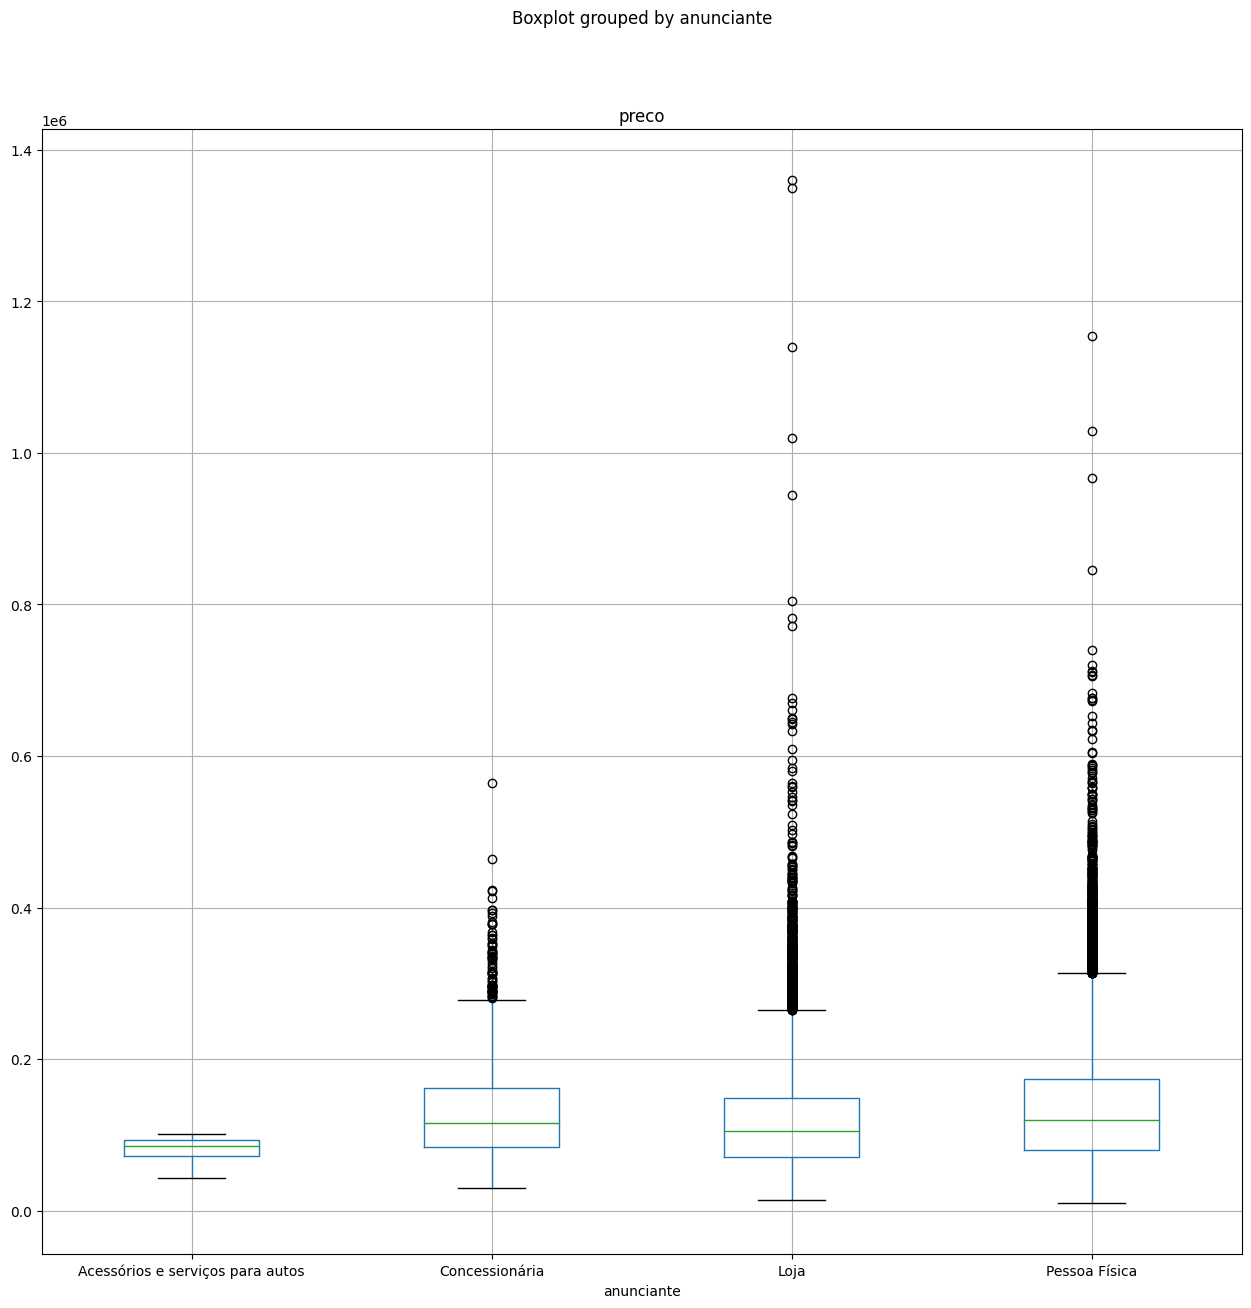

In [82]:
# Variáveis categóricas
# 'anunciante'
df_cars_train.boxplot(column='preco', by='anunciante', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('anunciante')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

3.659744169156661e-31
Há correlação entre as duas variáveis.


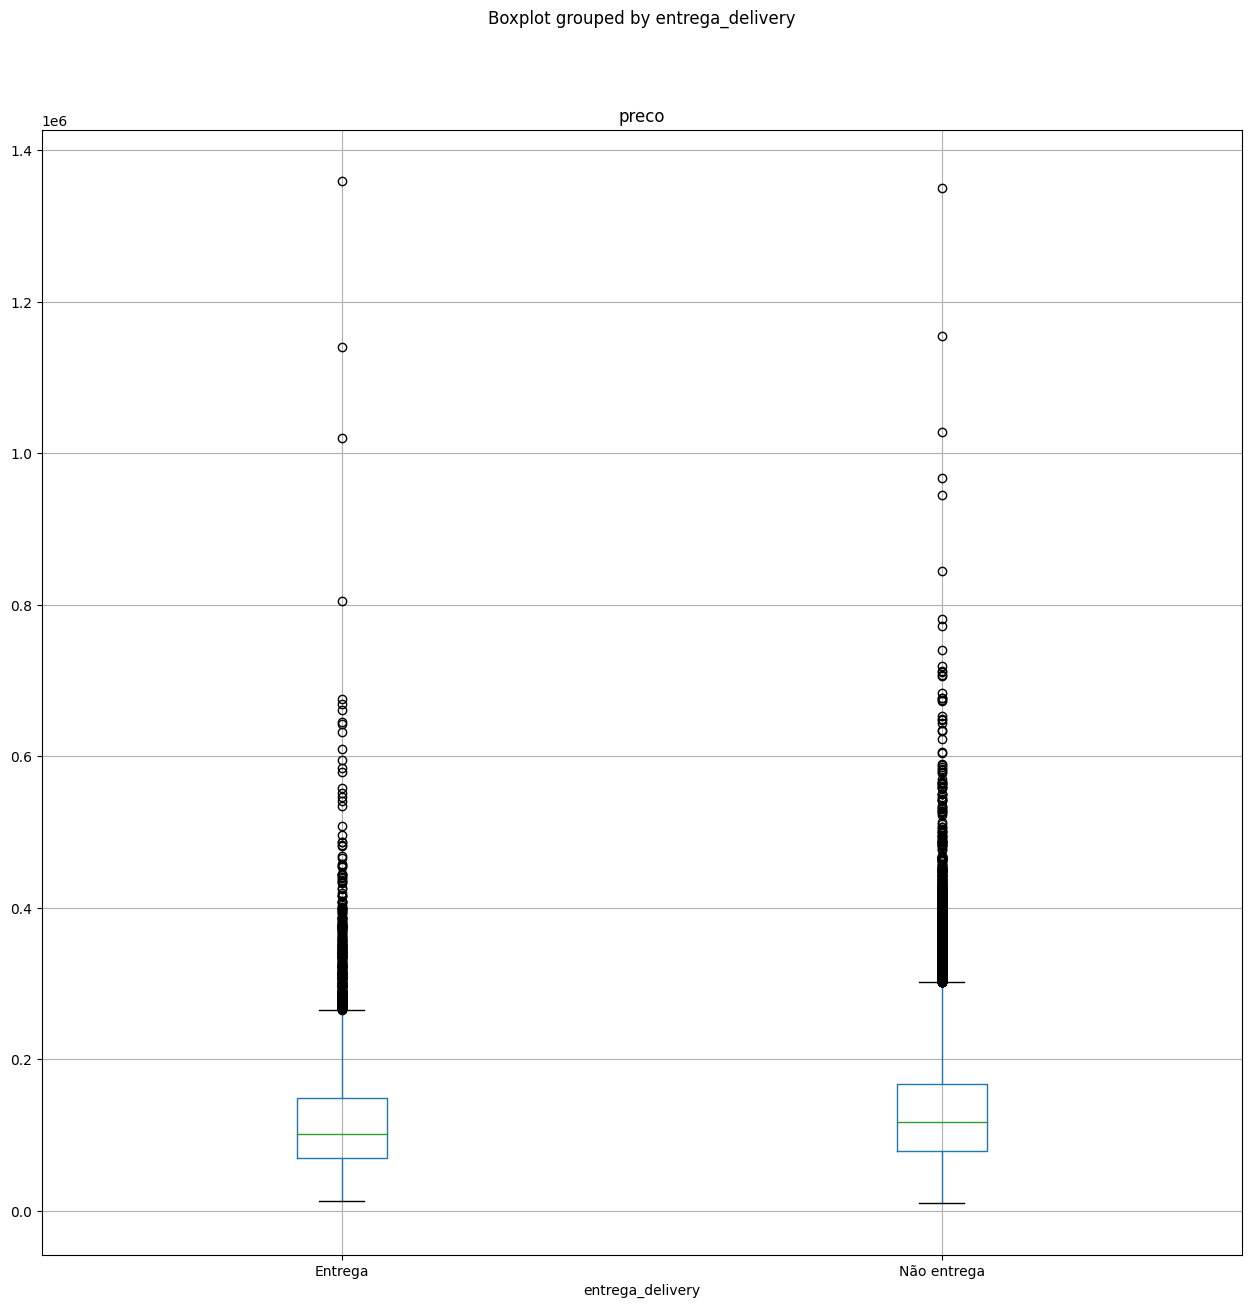

In [83]:
# Variáveis categóricas
# 'entrega_delivery'
df_cars_train.boxplot(column='preco', by='entrega_delivery', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('entrega_delivery')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

3.6273206936415564e-20
Há correlação entre as duas variáveis.


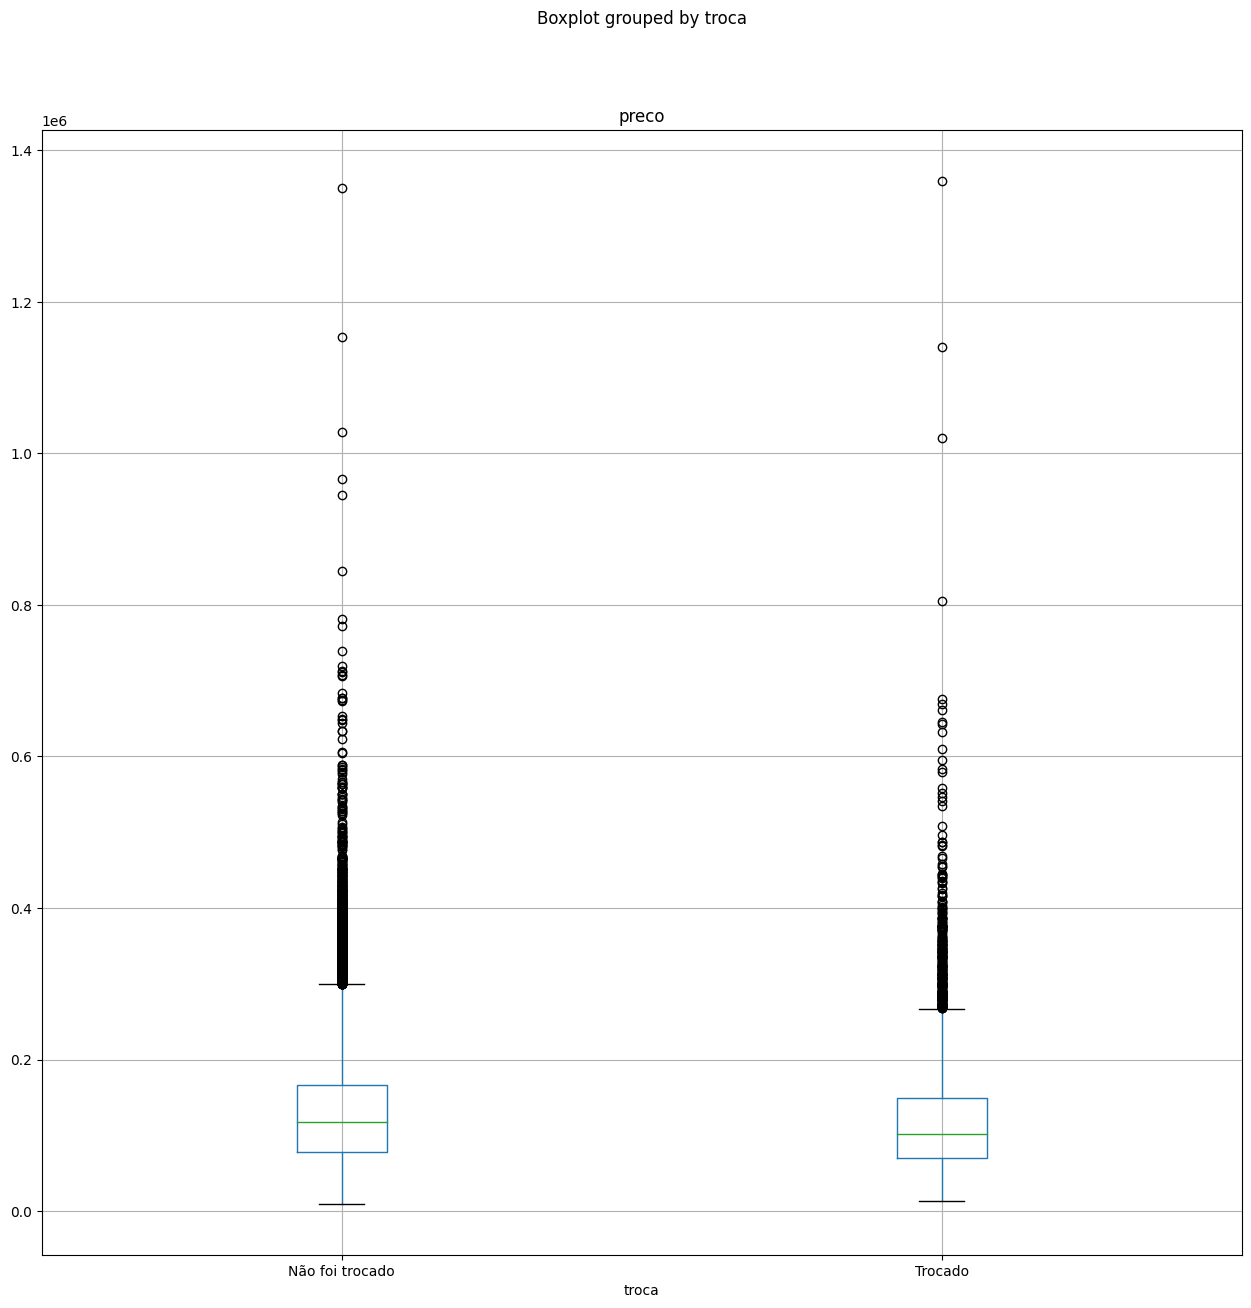

In [84]:
# Variáveis categóricas
# 'troca'
df_cars_train.boxplot(column='preco', by='troca', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('troca')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

1.785137309695187e-44
Há correlação entre as duas variáveis.


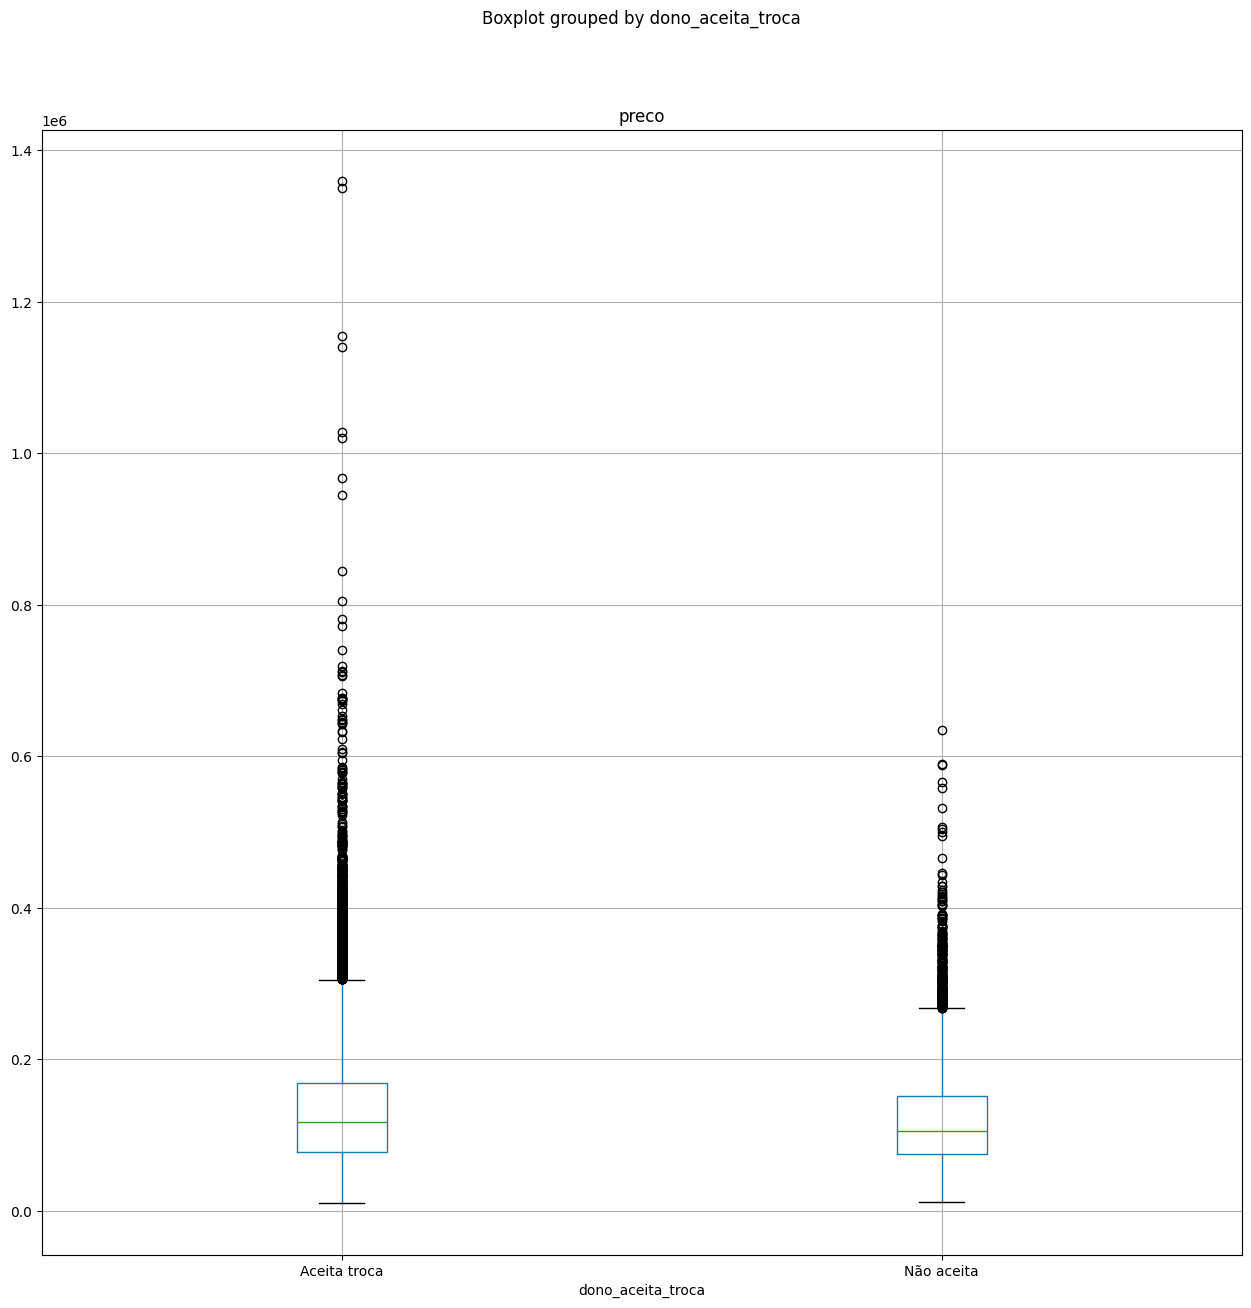

In [85]:
# Variáveis categóricas
# 'dono_aceita_troca'
df_cars_train.boxplot(column='preco', by='dono_aceita_troca', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('dono_aceita_troca')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

2.575143072609137e-37
Há correlação entre as duas variáveis.


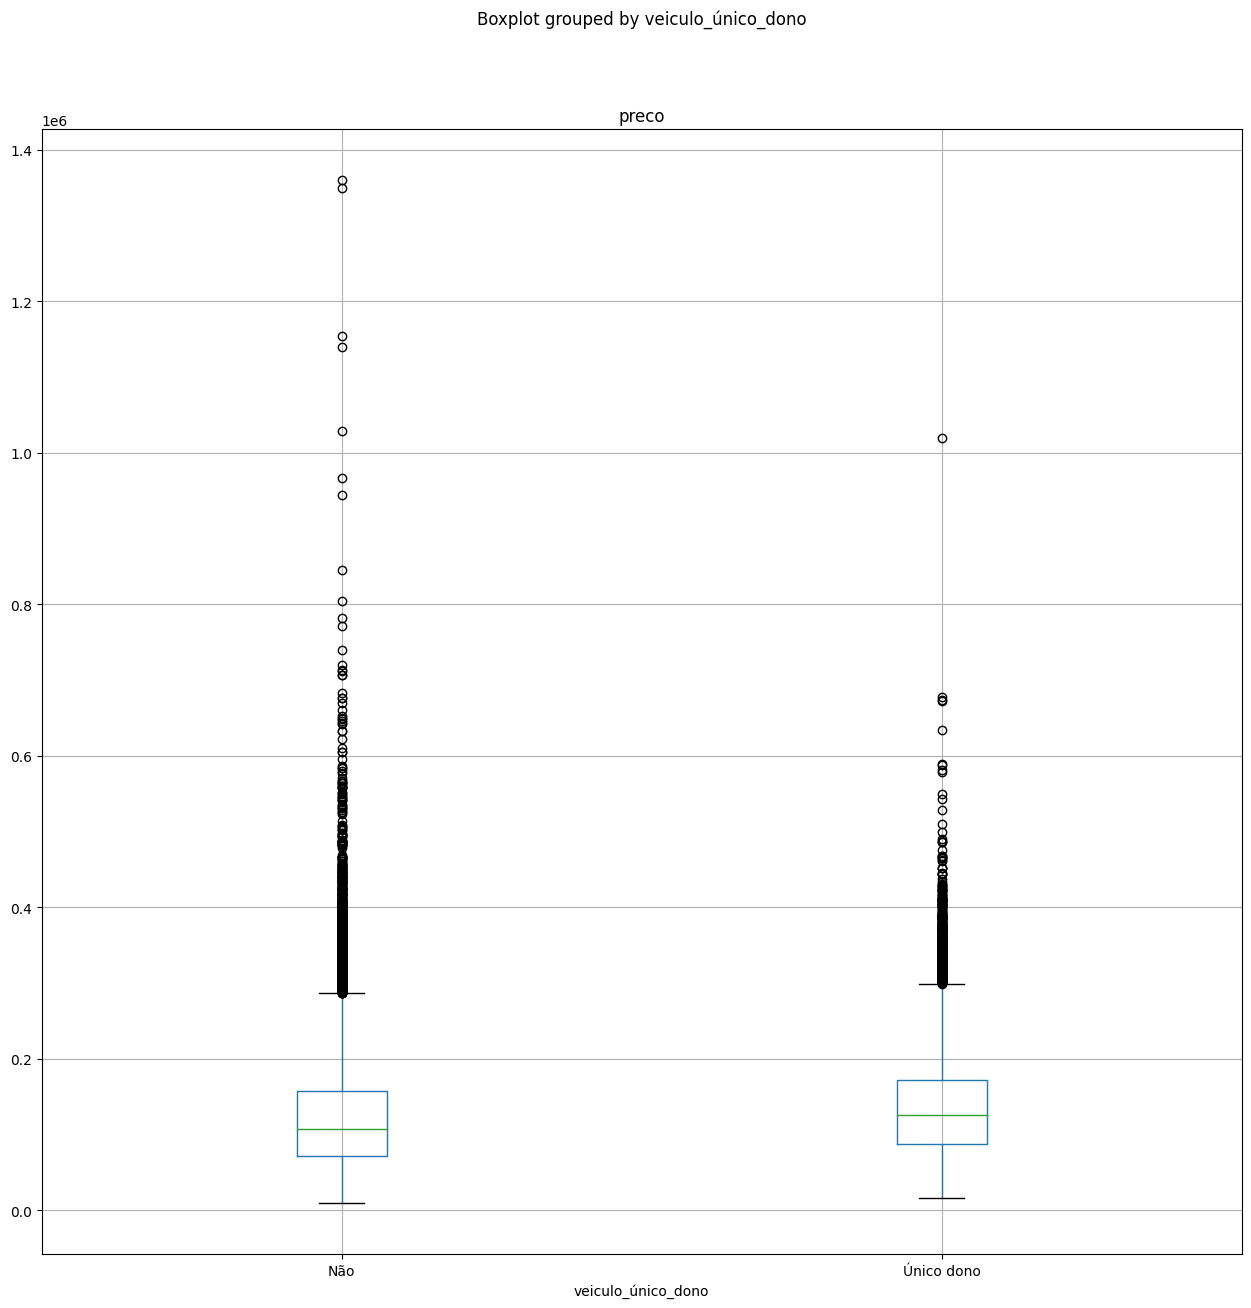

In [86]:
# Variáveis categóricas
# 'veiculo_único_dono'
df_cars_train.boxplot(column='preco', by='veiculo_único_dono', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('veiculo_único_dono')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

2.856920631250836e-212
Há correlação entre as duas variáveis.


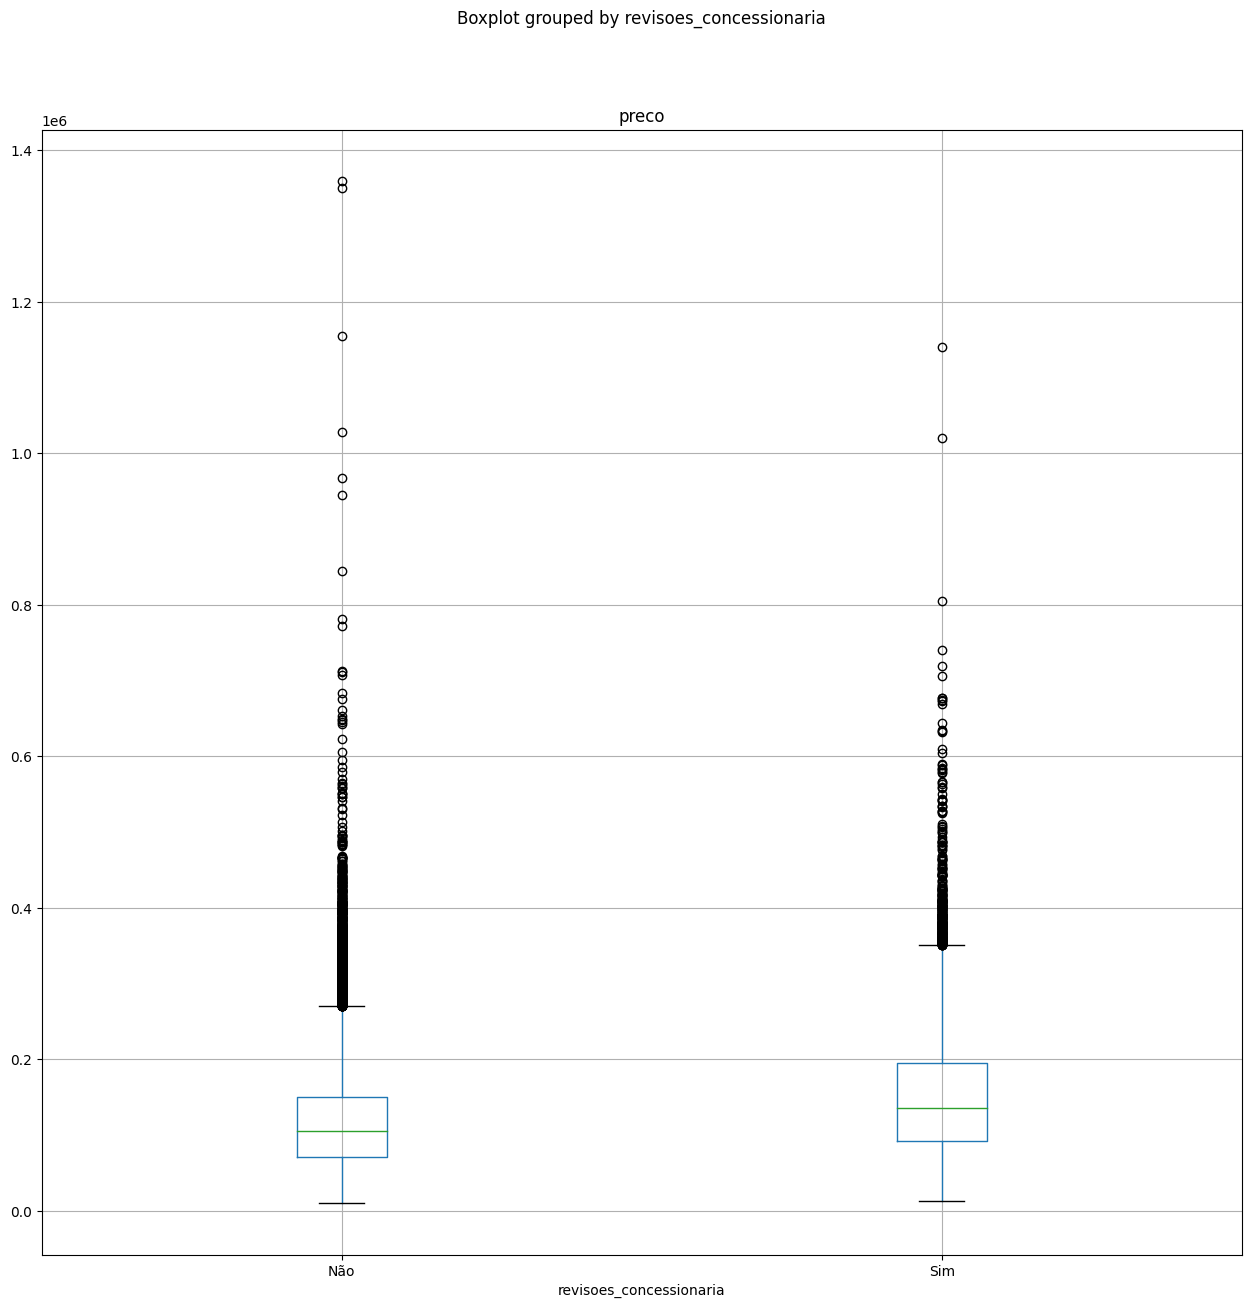

In [87]:
# Variáveis categóricas
# 'revisoes_concessionaria'
df_cars_train.boxplot(column='preco', by='revisoes_concessionaria', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('revisoes_concessionaria')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

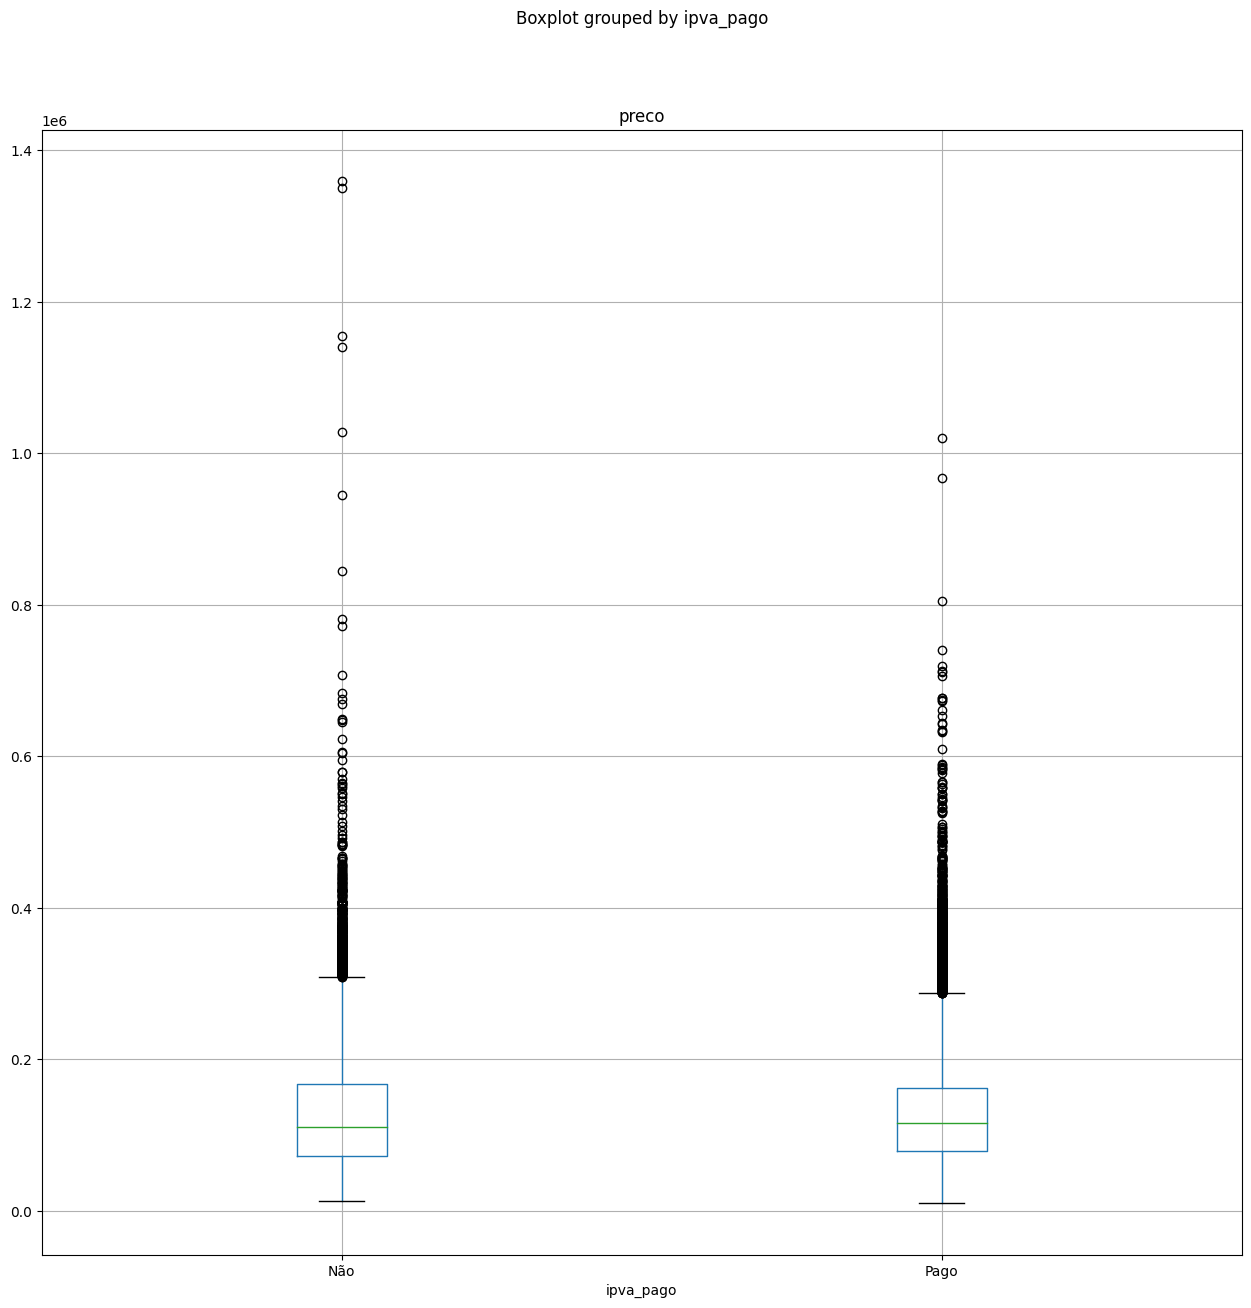

In [88]:
# Variáveis categóricas
# 'ipva_pago'
df_cars_train.boxplot(column='preco', by='ipva_pago', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('ipva_pago')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

0.006310358527623941
Há correlação entre as duas variáveis.


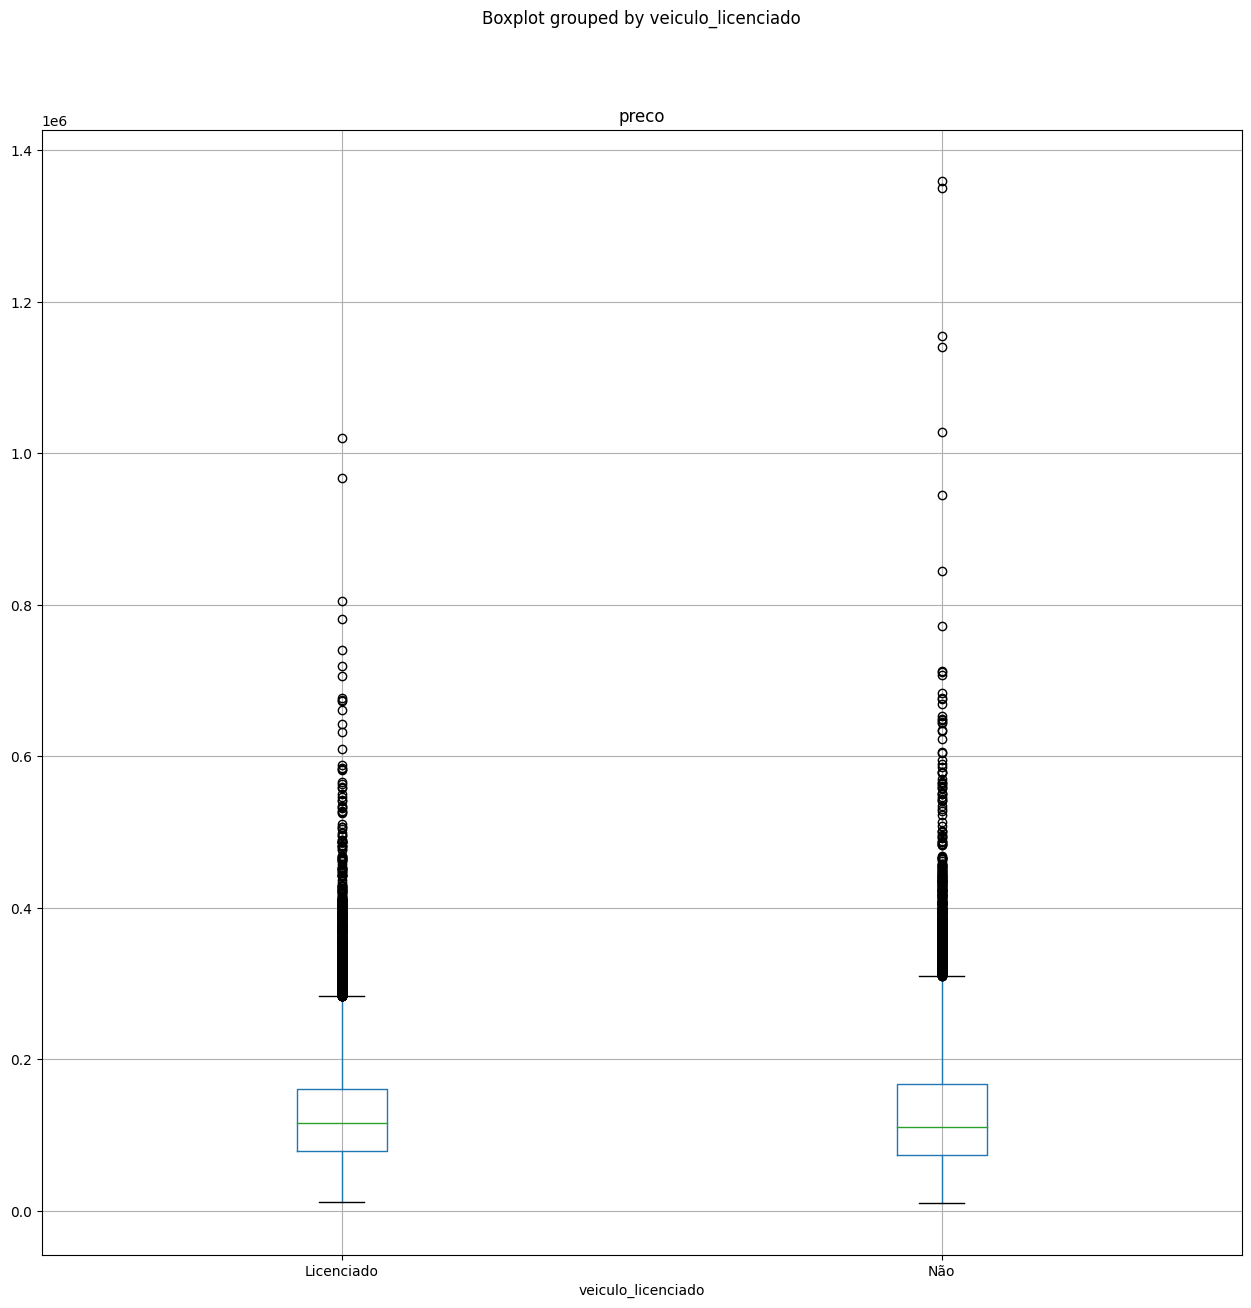

In [103]:
# Variáveis categóricas
# 'veiculo_licenciado'
df_cars_train.boxplot(column='preco', by='veiculo_licenciado', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('veiculo_licenciado')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
print(anova_resultados[1])
if anova_resultados[1] < 0.05:
    
    print("Há correlação entre as duas variáveis.")

9.769598578286142e-222
Há correlação entre as duas variáveis.


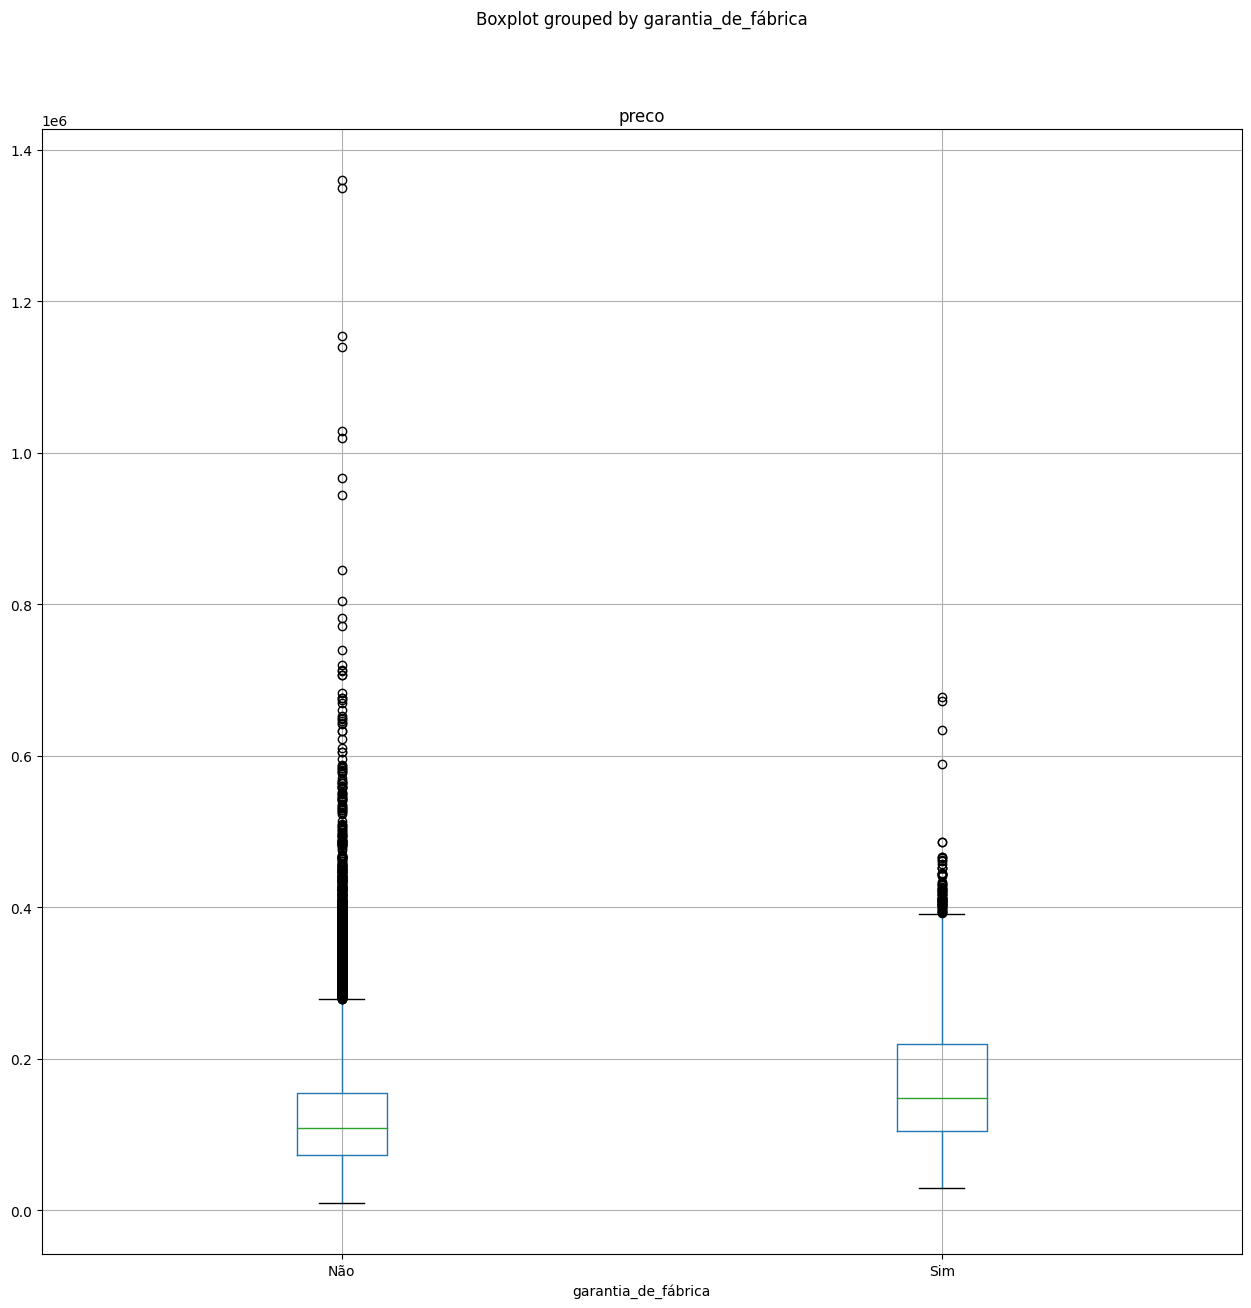

In [90]:
# Variáveis categóricas
# 'garantia_de_fábrica'
df_cars_train.boxplot(column='preco', by='garantia_de_fábrica', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('garantia_de_fábrica')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

3.9007270660820156e-90
Há correlação entre as duas variáveis.


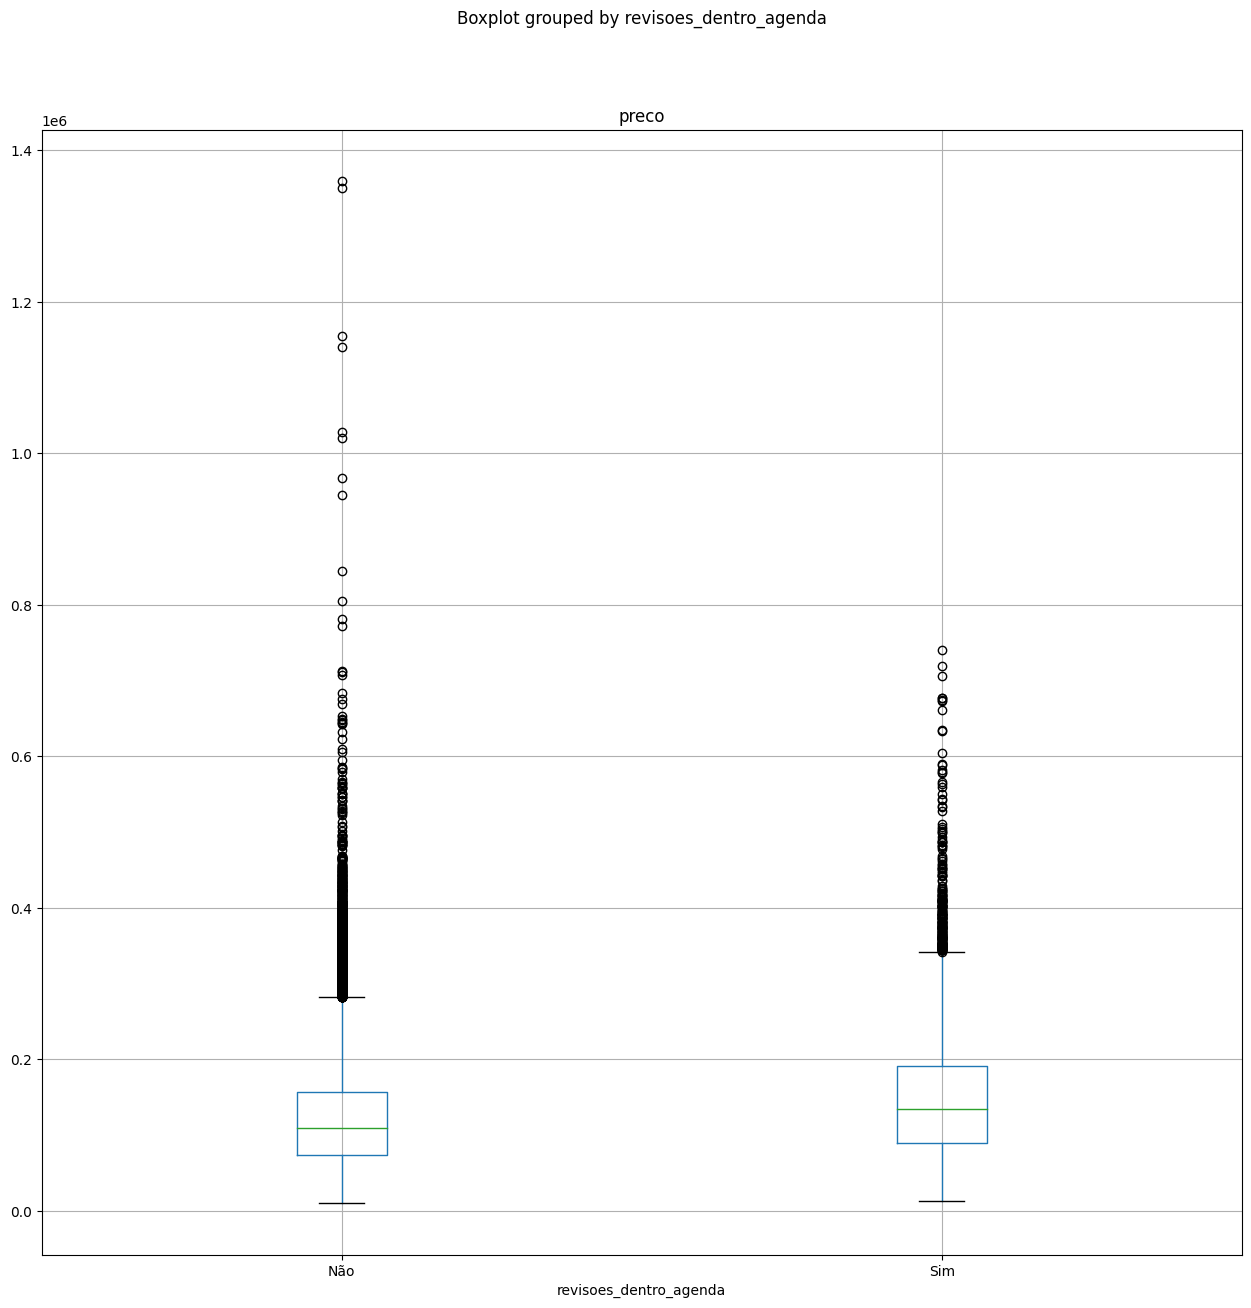

In [95]:
# Variáveis categóricas
# 'revisoes_dentro_agenda'
df_cars_train.boxplot(column='preco', by='revisoes_dentro_agenda', figsize=(15,15), vert=True)

categorias = df_cars_train.groupby('revisoes_dentro_agenda')['preco'].apply(list)
anova_resultados = f_oneway(*categorias)
if anova_resultados[1] < 0.05:
    print(anova_resultados[1])
    print("Há correlação entre as duas variáveis.")

In [107]:
# Resultados ANOVA

categorias = ['num_fotos', 'marca', 'cilindrada', 'tipo_combustivel', 'ano_modelo', 'cambio', 'num_portas', 'tipo', 
              'blindado', 'cor', 'tipo_vendedor', 'estado_vendedor', 'anunciante', 'entrega_delivery', 'troca', 
              'dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago', 'veiculo_licenciado', 
              'garantia_de_fábrica', 'revisoes_dentro_agenda']

categoria_a_remover = []

for categoria in categorias:
    categoria_lista = df_cars_train.groupby(categoria)['preco'].apply(list)
    anova_resultados = f_oneway(*categoria_lista)
    
    if (anova_resultados[1] < 0.05):
        print('[' + str(categoria) + ']', 'está relacionada ao target')
    else:
        categoria_a_remover.append(categoria)
        print('[' + str(categoria) + ']', 'NÃO está relacionada ao target')
    

[num_fotos] está relacionada ao target
[marca] está relacionada ao target
[cilindrada] está relacionada ao target
[tipo_combustivel] está relacionada ao target
[ano_modelo] está relacionada ao target
[cambio] está relacionada ao target
[num_portas] está relacionada ao target
[tipo] está relacionada ao target
[blindado] está relacionada ao target
[cor] está relacionada ao target
[tipo_vendedor] está relacionada ao target
[estado_vendedor] está relacionada ao target
[anunciante] está relacionada ao target
[entrega_delivery] está relacionada ao target
[troca] está relacionada ao target
[dono_aceita_troca] está relacionada ao target
[veiculo_único_dono] está relacionada ao target
[revisoes_concessionaria] está relacionada ao target
[ipva_pago] NÃO está relacionada ao target
[veiculo_licenciado] está relacionada ao target
[garantia_de_fábrica] está relacionada ao target
[revisoes_dentro_agenda] está relacionada ao target


In [ ]:
for categoria in categoria_a_remover:
    df_cars_train.drop(categoria, axis=1, inplace=True)

In [112]:
# Final columns
df_cars_train.columns

Index(['num_fotos', 'marca', 'cilindrada', 'tipo_combustivel', 'ano_modelo',
       'hodometro', 'cambio', 'num_portas', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'estado_vendedor', 'anunciante', 'entrega_delivery',
       'troca', 'dono_aceita_troca', 'veiculo_único_dono',
       'revisoes_concessionaria', 'veiculo_licenciado', 'garantia_de_fábrica',
       'revisoes_dentro_agenda', 'preco'],
      dtype='object')

In [126]:
# Tranformando o tipo de variáveis categóricas numérica para strings
df_cars_train = df_cars_train.astype({'num_fotos': 'str', 'ano_modelo': 'str', 'num_portas': 'str'})

In [133]:
# Convertendo as variáveis categóricas para o aprendizado de máquina
df_cars_train_ML = pd.get_dummies(df_cars_train)

In [190]:
# Separando as features do target
df_cars_train_ML_features = df_cars_train_ML.drop(['preco'], axis=1)
df_cars_train_ML_target = df_cars_train_ML['preco']

X = df_cars_train_ML_features.values
y = df_cars_train_ML_target.values
print(type(X))

<class 'numpy.ndarray'>


In [159]:
# Como não há valores discrepantes, decidi por usar a padronização
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_fit = scaler.fit(X)
X = scaler_fit.transform(X)
df_X_2 = pd.DataFrame(X)
df_X_2.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
count,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,...,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.00,29584.0,29584.0
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.0,-0.0
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0
min,-1.79,-0.08,-0.03,-0.07,-0.16,-0.26,-0.32,-0.29,-0.19,-0.09,...,-1.36,-0.74,-1.49,-0.67,-1.08,-0.93,-2.40,-0.42,-2.0,-0.5
25%,-0.84,-0.08,-0.03,-0.07,-0.16,-0.26,-0.32,-0.29,-0.19,-0.09,...,-1.36,-0.74,-1.49,-0.67,-1.08,-0.93,0.42,-0.42,0.5,-0.5
50%,-0.03,-0.08,-0.03,-0.07,-0.16,-0.26,-0.32,-0.29,-0.19,-0.09,...,0.74,-0.74,0.67,-0.67,0.93,-0.93,0.42,-0.42,0.5,-0.5
75%,0.72,-0.08,-0.03,-0.07,-0.16,-0.26,-0.32,-0.29,-0.19,-0.09,...,0.74,1.36,0.67,1.49,0.93,1.08,0.42,-0.42,0.5,-0.5
max,10.18,12.78,37.52,14.15,6.35,3.92,3.12,3.50,5.39,10.88,...,0.74,1.36,0.67,1.49,0.93,1.08,0.42,2.40,0.5,2.0


In [161]:
# Dividindo os dados em conjunto de treino e conjunto de teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [181]:
# Implementado Regressão Linear
from sklearn.linear_model import LinearRegression
from sklearn import metrics

regressao_modelo = LinearRegression()

regresao_modelo_fit = regressao_modelo.fit(X_train,y_train)
predicoes = regresao_modelo_fit.predict(X_test)

# Desempenho do algoritmo com o conjunto de treino
print('### TREINO ###')
print('R2_score:',metrics.r2_score(y_train, regressao_modelo.predict(X_train)))
# Desempenho do algoritmo com o conjunto de teste
print('### TESTE ###')
print('R2_score:',metrics.r2_score(y_test, predicoes))

# O resultado negativo indica que o modelo está performando pior que se fosse utilizada a média dos preços para a previsão.


ImportError: cannot import name 'DecisionTreeRegressor' from 'sklearn.linear_model' (c:\Users\julia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\__init__.py)

In [184]:
# Implementado Árvore de Decisão
from sklearn.tree import DecisionTreeRegressor

arvore_modelo = DecisionTreeRegressor(max_depth = 3, criterion = 'friedman_mse')

arvore_modelo_fit = arvore_modelo.fit(X_train,y_train)
predicoes = arvore_modelo_fit.predict(X_test)

# Desempenho do algoritmo com o conjunto de treino
print('### TREINO ###')
print('R2_score:',metrics.r2_score(y_train, arvore_modelo.predict(X_train)))
# Desempenho do algoritmo com o conjunto de teste
print('### TESTE ###')
print('R2_score:',metrics.r2_score(y_test, predicoes))

# O resultado 0.5 indica que o modelo está performando de forma ruim.

### TREINO ###
R2_score: 0.475629614441061
### TESTE ###
R2_score: 0.5083395740347182


In [185]:
# Implementado Floresta Aleatória
from sklearn.ensemble import RandomForestRegressor
floresta_modelo = RandomForestRegressor(max_depth=3, n_estimators=100, criterion='friedman_mse')

floresta_modelo_fit = floresta_modelo.fit(X_train, y_train)
predicoes = floresta_modelo_fit.predict(X_test)

# Desempenho do algoritmo com o conjunto de treino
print('### TREINO ###')
print('R2_score:',metrics.r2_score(y_train, floresta_modelo.predict(X_train)))
# Desempenho do algoritmo com o conjunto de teste
print('### TESTE ###')
print('R2_score:',metrics.r2_score(y_test, predicoes))

# O resultado 0.52 indica que o modelo está performando de forma ruim, embora melhor que a Árvore de Decisão.

### TREINO ###
R2_score: 0.4899959007487239
### TESTE ###
R2_score: 0.5237679941319551


In [186]:
# Implementado XGBoost
from xgboost import XGBRegressor
xgboost_modelo = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, objective='reg:linear', booster='gbtree')

xgboost_modelo_fit = xgboost_modelo.fit(X_train, y_train)
predicoes = xgboost_modelo_fit.predict(X_test)

# Desempenho do algoritmo com o conjunto de treino
print('### TREINO ###')
print('R2_score:',metrics.r2_score(y_train, xgboost_modelo.predict(X_train)))
# Desempenho do algoritmo com o conjunto de teste
print('### TESTE ###')
print('R2_score:',metrics.r2_score(y_test, predicoes))

# O resultado 0.7 indica que este modelo performa melhor.

[11:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
### TREINO ###
R2_score: 0.7508832779713399
### TESTE ###
R2_score: 0.7085580354187919


In [187]:
# Implementado KNN
from sklearn.neighbors import KNeighborsRegressor
knn_modelo = KNeighborsRegressor(n_neighbors=3)

knn_modelo_fit = knn_modelo.fit(X_train, y_train)
predicoes = knn_modelo_fit.predict(X_test)

# Desempenho do algoritmo com o conjunto de treino
print('### TREINO ###')
print('R2_score:',metrics.r2_score(y_train, knn_modelo.predict(X_train)))
# Desempenho do algoritmo com o conjunto de teste
print('### TESTE ###')
print('R2_score:',metrics.r2_score(y_test, predicoes))

# O resultado 0.58 indica que este modelo performa mal.

### TREINO ###
R2_score: 0.7893260911159806
### TESTE ###
R2_score: 0.5855436836771939


In [ ]:
# Entre todos os algoritmos testados, o que obteve melhores resultados foi o XGBoost.

In [191]:
def padronizar(X):
    scaler = StandardScaler()
    scaler_fit = scaler.fit(X)
    X = scaler_fit.transform(X)
    
    return X

def preparar_para_modelagem(df):
    # Excluindo coluna 'id':
    df.drop(['id'], axis=1, inplace=True)
        
    # Preenchendo valores NaN em 'num_fotos'
    df['num_fotos'].fillna(value=round(df['num_fotos'].mean()), inplace=True)
        
    # Reduzindo o número de categorias na variável 'marca'
    marca_frequencia = df['marca'].value_counts() / len(df)
    marcas_menos_frequentes = marca_frequencia[marca_frequencia<0.01]
    df.loc[df['marca'].isin(marcas_menos_frequentes.index.tolist()), 'marca'] = 'OUTRA'
        
    # Excluindo coluna 'modelo':
    df.drop(['modelo'], axis=1, inplace=True)

    # Dividindo a coluna 'versao' em duas novas variáveis: 'cilindrada' e 'tipo_combustivel'
        # Criando as novas colunas
    df.insert(3, 'cilindrada', np.NaN)
    df.insert(4, 'tipo_combustivel', np.NaN)

        # Preenchendo as novas colunas a partir da coluna 'versao'
    tipos = ['flex', 'gasolina', 'diesel', 'híbrido', 'hybrid']
    for i in range(len(df)):
        if 'elétrico' in df.loc[i, 'versao'].lower() or 'electric' in df.loc[i, 'versao'].lower():
            df.loc[i, 'tipo_combustivel'] = 'eletrico'
            df.loc[i, 'cilindrada'] = 2.0
        else:
            df.loc[i, 'cilindrada'] = float(df['versao'][i][0:3])
            for tipo in tipos:
                if tipo in df.loc[i, 'versao'].lower():                
                    if tipo == 'híbrido' or tipo == 'hybrid':
                        df.loc[i, 'tipo_combustivel'] = 'hibrido'
                    else:
                        df.loc[i, 'tipo_combustivel'] = tipo
                        
        # Preenchendo o 'tipo_combustivel' com a moda para as entradas que não continham essa informação
    df['tipo_combustivel'].fillna(value=(df['tipo_combustivel'].mode()[0]), inplace=True)
        
        # Excluindo coluna 'versao':
    df.drop(['versao'], axis=1, inplace=True)
            
        # Reduzindo o número de categorias na variável 'cilindrada'
    for i in range(len(df['cilindrada'])):
        if 0.5<=df.loc[i, 'cilindrada']<=1.4:
            df.loc[i, 'cilindrada'] = '0.5 - 1.4'
        elif 1.5<=df.loc[i, 'cilindrada']<=2.4:
            df.loc[i, 'cilindrada'] = '1.5 - 2.4'
        elif 2.5<=df.loc[i, 'cilindrada']<=3.4:
            df.loc[i, 'cilindrada'] = '2.5 - 3.4'
        elif 3.5<=df.loc[i, 'cilindrada']<=4.4:
            df.loc[i, 'cilindrada'] = '3.5 - 4.4'
        elif 4.5<=df.loc[i, 'cilindrada']<=5.4:
            df.loc[i, 'cilindrada'] = '4.5 - 5.4'
        else:
            df.loc[i, 'cilindrada'] = '5.5 - 6.7'
        
    # Excluindo coluna 'ano_de_fabricacao':
    df.drop(['ano_de_fabricacao'], axis=1, inplace=True)
    
    # Substituindo valores em 'blindado':
    df['blindado'].replace('N', 'Não', inplace=True)
    df['blindado'].replace('S', 'Sim', inplace=True)

    # Excluindo a coluna ['cidade_vendedor']
    df.drop('cidade_vendedor', axis=1, inplace=True)

    # Substituindo valores em 'entrega_delivery':
    df['entrega_delivery'] = df['entrega_delivery'].map({True: 'Entrega', False: 'Não entrega'})

    # Substituindo valores em 'troca':
    df['troca'] = df['troca'].map({True: 'Trocado', False: 'Não foi trocado'})
    
    # Excluindo a coluna ['elegivel_revisao']
    df.drop('elegivel_revisao', axis=1, inplace=True)
    
    # Substituindo valores em 'dono_aceita_troca':
    df['dono_aceita_troca'].fillna(value='Não aceita', inplace=True)
    
    # Substituindo valores em 'veiculo_único_dono':
    df['veiculo_único_dono'].fillna(value='Não', inplace=True)
    
    # Substituindo valores em 'revisoes_concessionaria':
    df['revisoes_concessionaria'].fillna(value='Não', inplace=True)
    df['revisoes_concessionaria'].replace('Todas as revisões feitas pela concessionária', 'Sim', inplace=True)
    
    # Excluindo a coluna 'ipva_pago':
    df.drop('ipva_pago', axis=1, inplace=True)
    
    # Substituindo valores em 'veiculo_licenciado':
    df['veiculo_licenciado'].fillna(value='Não', inplace=True)
    
    # Substituindo valores em 'garantia_de_fábrica':
    df['garantia_de_fábrica'].fillna(value='Não', inplace=True)
    df['garantia_de_fábrica'].replace('Garantia de fábrica', 'Sim', inplace=True)
    
    # Substituindo valores em 'revisoes_dentro_agenda':
    df['revisoes_dentro_agenda'].fillna(value='Não', inplace=True)
    df['revisoes_dentro_agenda'].replace('Todas as revisões feitas pela agenda do carro', 'Sim', inplace=True)
    
    # Excluindo a coluna ['veiculo_alienado']
    df.drop('veiculo_alienado', axis=1, inplace=True)
    
    # Tranformando o tipo de variáveis categóricas numéricas para strings
    df = df.astype({'num_fotos': 'str', 'ano_modelo': 'str', 'num_portas': 'str'})
    
    # Convertendo as variáveis categóricas para o aprendizado de máquina
    df = pd.get_dummies(df)
    
    return df

In [282]:
# Leitura do conjunto de dados
df_cars_train = pd.read_csv('cars_train.csv', sep='\t', encoding='utf_16_le')
df_cars_test = pd.read_csv('cars_test.csv', sep='\t', encoding='utf_16_le')
   
# Remoção das linhas duplicadas
df_cars_train.drop_duplicates()
df_cars_test.drop_duplicates()

# Informações para separar o dataframe mais tarde
size_train = len(df_cars_train)
size_test = len(df_cars_test)

# Concatenando os dois dataframes
df_cars_test.insert((df_cars_test.shape[1]), 'preco', np.NaN)
df = pd.concat([df_cars_train, df_cars_test],ignore_index=True)

# Preparando os conjuntos de dados para a modelagem
df_preparado = preparar_para_modelagem(df)

# Separando o dataframe em treino e teste
df_train_ML = df_preparado[0:size_train]
df_test_ML = df_preparado[size_train:len(df)]
df_test_ML.reset_index(drop=True, inplace=True)

# Separando as features do target no conjunto de treinamento e transformando em numpy array:
X_train = df_train_ML.drop(['preco'], axis=1).values
y_train = df_train_ML['preco'].values
    
# Transformando as features do conjunto de teste em numpy array:
X_test = df_test_ML.drop(['preco'], axis=1).values

# Padronizando os conjuntos de dados
X_train = padronizar(X_train)
X_test = padronizar(X_test)

# Implementando modelo XGBoost
xgboost_modelo = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, objective='reg:linear', booster='gbtree')
xgboost_modelo_fit = xgboost_modelo.fit(X_train, y_train)

# Fazendo predições para cars_test.csv    
predicoes = xgboost_modelo_fit.predict(X_test)

[14:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [284]:
print(predicoes)

[ 72083.695  82760.97  234896.19  ... 100823.414 130087.305 282044.34 ]


In [288]:
new_df = pd.DataFrame(df_cars_test['id'])
new_df.insert((new_df.shape[1]), 'preco', predicoes)
print(new_df)

                                           id          preco
0      13518783164498355150900635905895481162   72083.695312
1     299896161723793383246777788797566040330   82760.968750
2     316180649972302128246133616457018378621  234896.187500
3     222527157104148385909188217274642813298  114686.265625
4     160460343059850745858546502614838368036  101963.007812
...                                       ...            ...
9857  270530958308663978454359593206239054667  105641.375000
9858   35444226755331218706378362485070904721  256778.328125
9859  151927592621490440610866139377092833936  100823.414062
9860  118047837484645467440786911677256539035  130087.304688
9861  332784980027104367393384305973418103109  282044.343750

[9862 rows x 2 columns]
